In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import make_column_transformer, ColumnTransformer
import statsmodels.api as sm
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
sns.set()

In [2]:
data = pd.read_csv('car_price_prediction.csv')
data.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [3]:
df = data.copy()

# FEATURE ENGINEERING

## Understand Data

In [4]:
df.shape

(19237, 18)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  object 
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod. year        19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather interior  19237 non-null  object 
 8   Fuel type         19237 non-null  object 
 9   Engine volume     19237 non-null  object 
 10  Mileage           19237 non-null  object 
 11  Cylinders         19237 non-null  float64
 12  Gear box type     19237 non-null  object 
 13  Drive wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  object 
 16  Color             19237 non-null  object

In [6]:
df.describe().round(2)

,ID,Price,Prod. year,Cylinders,Airbags
count,19237.00,19237.00,19237.00,19237.00,19237.00
mean,45576535.89,18555.93,2010.91,4.58,6.58
std,936591.42,190581.27,5.67,1.20,4.32
min,20746880.00,1.00,1939.00,1.00,0.00
25%,45698374.00,5331.00,2009.00,4.00,4.00
50%,45772308.00,13172.00,2012.00,4.00,6.00
75%,45802036.00,22075.00,2015.00,4.00,12.00
max,45816654.00,26307500.00,2020.00,16.00,16.00


* <font color='brown'>**Loos like Price is highly skewed to the right**</font>

In [7]:
df.describe(include='object')

,Levy,Manufacturer,Model,Category,Leather interior,Fuel type,Engine volume,Mileage,Gear box type,Drive wheels,Doors,Wheel,Color
count,19237,19237,19237,19237,19237,19237,19237,19237,19237,19237,19237,19237,19237
unique,559,65,1590,11,2,7,107,7687,4,3,3,2,16
top,-,HYUNDAI,Prius,Sedan,Yes,Petrol,2,0 km,Automatic,Front,04-May,Left wheel,Black
freq,5819,3769,1083,8736,13954,10150,3916,721,13514,12874,18332,17753,5033


* <font color = 'brown'>**levy, Engine volume and Mileage must convert to the numeric values**</font>
* <font color = 'brown'>**Instead of prod.year, age of the car can be calculate**</font>

## Data preprossessing and Cleaning

In [8]:
df['Levy'].unique()

array(['1399', '1018', '-', '862', '446', '891', '761', '751', '394',
       '1053', '1055', '1079', '810', '2386', '1850', '531', '586',
       '1249', '2455', '583', '1537', '1288', '915', '1750', '707',
       '1077', '1486', '1091', '650', '382', '1436', '1194', '503',
       '1017', '1104', '639', '629', '919', '781', '530', '640', '765',
       '777', '779', '934', '769', '645', '1185', '1324', '830', '1187',
       '1111', '760', '642', '1604', '1095', '966', '473', '1138', '1811',
       '988', '917', '1156', '687', '11714', '836', '1347', '2866',
       '1646', '259', '609', '697', '585', '475', '690', '308', '1823',
       '1361', '1273', '924', '584', '2078', '831', '1172', '893', '1872',
       '1885', '1266', '447', '2148', '1730', '730', '289', '502', '333',
       '1325', '247', '879', '1342', '1327', '1598', '1514', '1058',
       '738', '1935', '481', '1522', '1282', '456', '880', '900', '798',
       '1277', '442', '1051', '790', '1292', '1047', '528', '1211',
       

In [9]:
df['Levy'] = [0 if i=='-' else int(i) for i in df['Levy']]

In [10]:
df['Levy'].dtype

dtype('int64')

In [11]:
df['Engine volume'].unique()

array(['3.5', '3', '1.3', '2.5', '2', '1.8', '2.4', '4', '1.6', '3.3',
       '2.0 Turbo', '2.2 Turbo', '4.7', '1.5', '4.4', '3.0 Turbo',
       '1.4 Turbo', '3.6', '2.3', '1.5 Turbo', '1.6 Turbo', '2.2',
       '2.3 Turbo', '1.4', '5.5', '2.8 Turbo', '3.2', '3.8', '4.6', '1.2',
       '5', '1.7', '2.9', '0.5', '1.8 Turbo', '2.4 Turbo', '3.5 Turbo',
       '1.9', '2.7', '4.8', '5.3', '0.4', '2.8', '3.2 Turbo', '1.1',
       '2.1', '0.7', '5.4', '1.3 Turbo', '3.7', '1', '2.5 Turbo', '2.6',
       '1.9 Turbo', '4.4 Turbo', '4.7 Turbo', '0.8', '0.2 Turbo', '5.7',
       '4.8 Turbo', '4.6 Turbo', '6.7', '6.2', '1.2 Turbo', '3.4',
       '1.7 Turbo', '6.3 Turbo', '2.7 Turbo', '4.3', '4.2', '2.9 Turbo',
       '0', '4.0 Turbo', '20', '3.6 Turbo', '0.3', '3.7 Turbo', '5.9',
       '5.5 Turbo', '0.2', '2.1 Turbo', '5.6', '6', '0.7 Turbo',
       '0.6 Turbo', '6.8', '4.5', '0.6', '7.3', '0.1', '1.0 Turbo', '6.3',
       '4.5 Turbo', '0.8 Turbo', '4.2 Turbo', '3.1', '5.0 Turbo', '6.4',
       '3

In [12]:
df['Engine volume'] = [float(i.split()[0]) for i in df['Engine volume']]

In [13]:
df['Engine volume'].dtype

dtype('float64')

In [14]:
df['Mileage'].unique()

array(['186005 km', '192000 km', '200000 km', ..., '140607 km',
       '307325 km', '186923 km'], dtype=object)

In [15]:
df['Mileage'] = [float(i.split()[0]) for i in df['Mileage']]

In [16]:
df['Engine volume'].dtype

dtype('float64')

In [17]:
df['Doors'].unique()

array(['04-May', '02-Mar', '>5'], dtype=object)

* <font color = 'brown'>**Looks like there was a data entry error. 4 doors and 2 doors are entered as dates.**</font>

In [18]:
df['Doors'] = df['Doors'].map({'04-May':'4','02-Mar':'2', '>5': '>5'})

In [19]:
df['Doors'].unique()

array(['4', '2', '>5'], dtype=object)

In [20]:
df['age']=2023-df['Prod. year']

In [21]:
df.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,age
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005.0,6.0,Automatic,4x4,4,Left wheel,Silver,12,13
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3.0,192000.0,6.0,Tiptronic,4x4,4,Left wheel,Black,8,12
2,45774419,8467,0,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000.0,4.0,Variator,Front,4,Right-hand drive,Black,2,17
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966.0,4.0,Automatic,4x4,4,Left wheel,White,0,12
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901.0,4.0,Automatic,Front,4,Left wheel,Silver,4,9


In [22]:
df.drop('Prod. year',axis=1, inplace=True)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  int64  
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Category          19237 non-null  object 
 6   Leather interior  19237 non-null  object 
 7   Fuel type         19237 non-null  object 
 8   Engine volume     19237 non-null  float64
 9   Mileage           19237 non-null  float64
 10  Cylinders         19237 non-null  float64
 11  Gear box type     19237 non-null  object 
 12  Drive wheels      19237 non-null  object 
 13  Doors             19237 non-null  object 
 14  Wheel             19237 non-null  object 
 15  Color             19237 non-null  object 
 16  Airbags           19237 non-null  int64 

## Handling Missing Values

In [24]:
df.isna().sum()

ID                  0
Price               0
Levy                0
Manufacturer        0
Model               0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
age                 0
dtype: int64

* <font color = 'brown'>**No missing values in the data set**</font>

## Handling Duplicates

In [25]:
df.duplicated().sum()

313

* <font color = 'brown'>**There are 313 Duplicates**</font>

In [26]:
df.drop_duplicates(inplace=True)

In [27]:
df.duplicated().sum()

0

In [28]:
df.drop('ID',axis=1,inplace=True) # Here ID column was dropped because there is no importance of the column

In [29]:
df = df.reset_index(drop=True)

In [30]:
df

,Price,Levy,Manufacturer,Model,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,age
0,13328,1399,LEXUS,RX 450,Jeep,Yes,Hybrid,3.5,186005.0,6.0,Automatic,4x4,4,Left wheel,Silver,12,13
1,16621,1018,CHEVROLET,Equinox,Jeep,No,Petrol,3.0,192000.0,6.0,Tiptronic,4x4,4,Left wheel,Black,8,12
2,8467,0,HONDA,FIT,Hatchback,No,Petrol,1.3,200000.0,4.0,Variator,Front,4,Right-hand drive,Black,2,17
3,3607,862,FORD,Escape,Jeep,Yes,Hybrid,2.5,168966.0,4.0,Automatic,4x4,4,Left wheel,White,0,12
4,11726,446,HONDA,FIT,Hatchback,Yes,Petrol,1.3,91901.0,4.0,Automatic,Front,4,Left wheel,Silver,4,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18919,8467,0,MERCEDES-BENZ,CLK 200,Coupe,Yes,CNG,2.0,300000.0,4.0,Manual,Rear,2,Left wheel,Silver,5,24
18920,15681,831,HYUNDAI,Sonata,Sedan,Yes,Petrol,2.4,161600.0,4.0,Tiptronic,Front,4,Left wheel,Red,8,12
18921,26108,836,HYUNDAI,Tucson,Jeep,Yes,Diesel,2.0,116365.0,4.0,Automatic,Front,4,Left wheel,Grey,4,13
18922,5331,1288,CHEVROLET,Captiva,Jeep,Yes,Diesel,2.0,51258.0,4.0,Automatic,Front,4,Left wheel,Black,4,16


In [31]:
numerical_data = df.select_dtypes(include='number')
numerical_data.head()

,Price,Levy,Engine volume,Mileage,Cylinders,Airbags,age
0,13328,1399,3.5,186005.0,6.0,12,13
1,16621,1018,3.0,192000.0,6.0,8,12
2,8467,0,1.3,200000.0,4.0,2,17
3,3607,862,2.5,168966.0,4.0,0,12
4,11726,446,1.3,91901.0,4.0,4,9


In [32]:
categorical_data = df.select_dtypes(include='object')
categorical_data.head()

,Manufacturer,Model,Category,Leather interior,Fuel type,Gear box type,Drive wheels,Doors,Wheel,Color
0,LEXUS,RX 450,Jeep,Yes,Hybrid,Automatic,4x4,4,Left wheel,Silver
1,CHEVROLET,Equinox,Jeep,No,Petrol,Tiptronic,4x4,4,Left wheel,Black
2,HONDA,FIT,Hatchback,No,Petrol,Variator,Front,4,Right-hand drive,Black
3,FORD,Escape,Jeep,Yes,Hybrid,Automatic,4x4,4,Left wheel,White
4,HONDA,FIT,Hatchback,Yes,Petrol,Automatic,Front,4,Left wheel,Silver


## Handling outliers

#### Understand distribution of each numerical variables

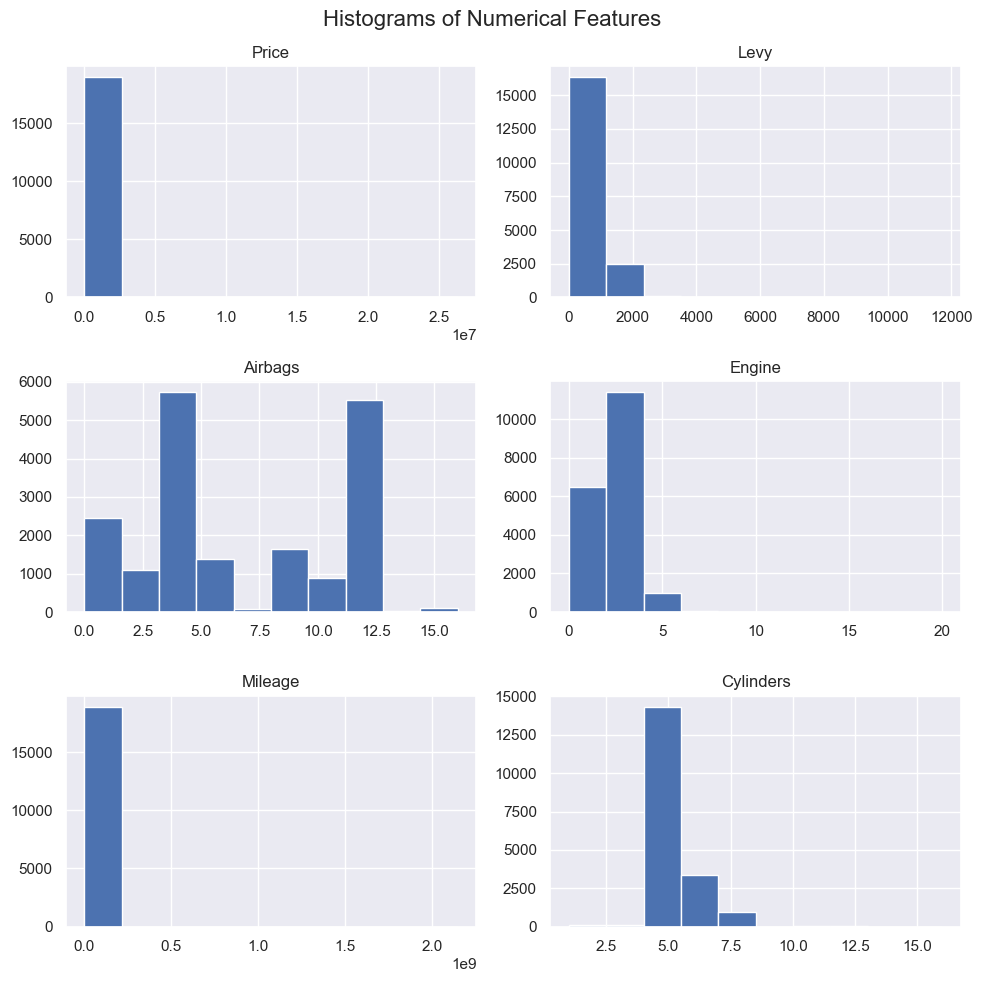

In [33]:
fig, axes = plt.subplots(3,2, figsize=(10, 10))

axes[0,0].hist(numerical_data['Price'])
axes[0,1].hist(numerical_data['Levy'])
axes[1,0].hist(numerical_data['Airbags'])
axes[1,1].hist(numerical_data['Engine volume'])
axes[2,0].hist(numerical_data['Mileage'])
axes[2,1].hist(numerical_data['Cylinders'])

axes[0, 0].set_title('Price')
axes[0, 1].set_title('Levy')
axes[1, 0].set_title('Airbags')
axes[1, 1].set_title('Engine')
axes[2, 0].set_title('Mileage')
axes[2, 1].set_title('Cylinders')

plt.suptitle('Histograms of Numerical Features', fontsize = 16)
plt.tight_layout()
plt.show()

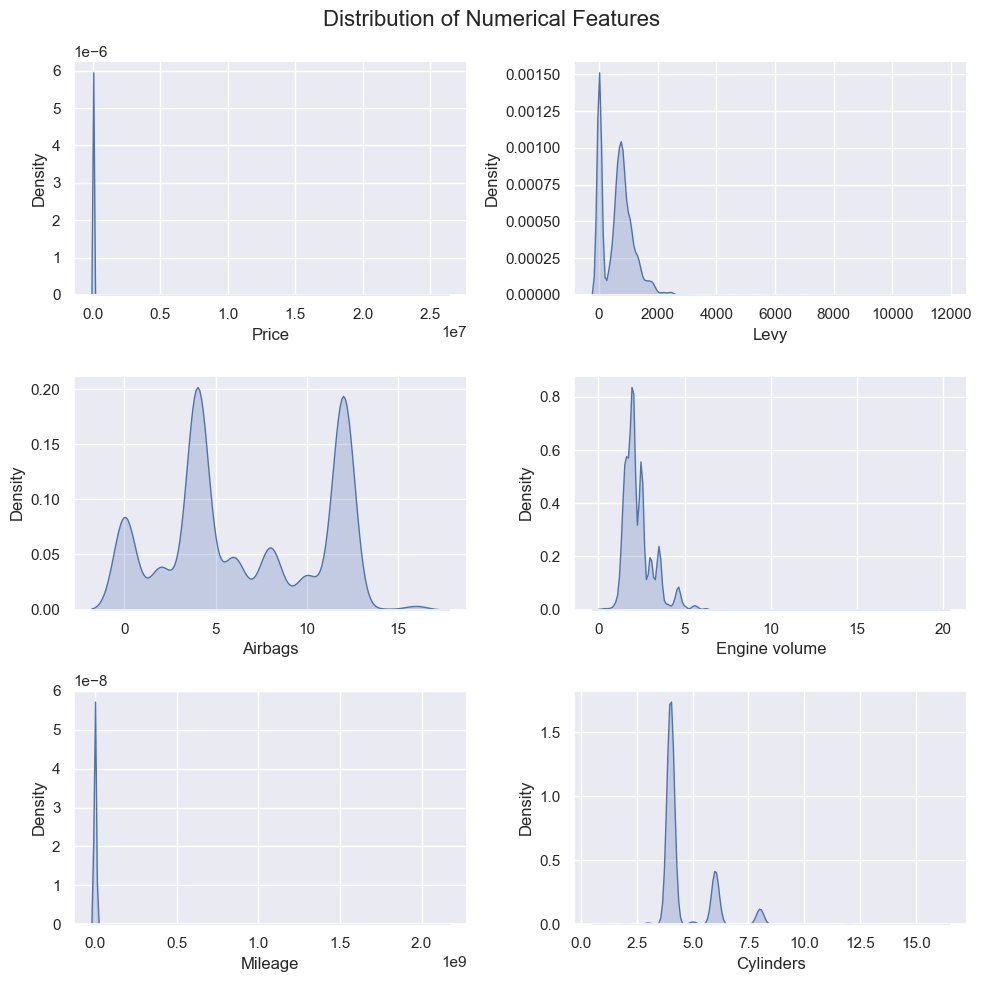

In [34]:
fig, axes = plt.subplots(3,2, figsize=(10, 10))

sns.kdeplot(numerical_data['Price'], fill=True, ax=axes[0,0])
sns.kdeplot(numerical_data['Levy'], fill=True, ax=axes[0,1])
sns.kdeplot(numerical_data['Airbags'], fill=True, ax=axes[1,0])
sns.kdeplot(numerical_data['Engine volume'], fill=True, ax=axes[1,1])
sns.kdeplot(numerical_data['Mileage'], fill=True, ax=axes[2,0])
sns.kdeplot(numerical_data['Cylinders'], fill=True, ax=axes[2,1])

fig.suptitle('Distribution of Numerical Features', fontsize=16)
plt.tight_layout()
plt.show()

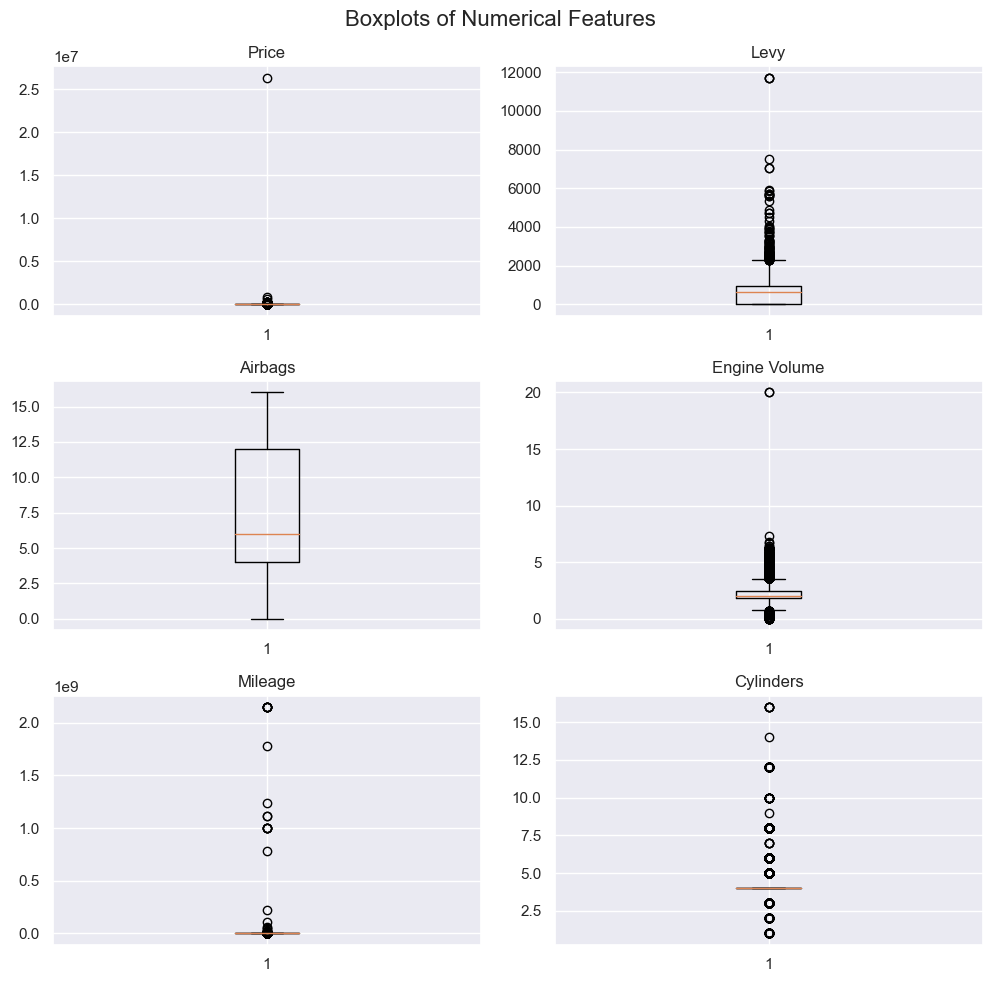

In [35]:
fig, axes = plt.subplots(3,2, figsize=(10, 10))

axes[0,0].boxplot(numerical_data['Price'])
axes[0,1].boxplot(numerical_data['Levy'])
axes[1,0].boxplot(numerical_data['Airbags'])
axes[1,1].boxplot(numerical_data['Engine volume'])
axes[2,0].boxplot(numerical_data['Mileage'])
axes[2,1].boxplot(numerical_data['Cylinders'])

axes[0, 0].set_title('Price')
axes[0, 1].set_title('Levy')
axes[1, 0].set_title('Airbags')
axes[1, 1].set_title('Engine Volume')
axes[2, 0].set_title('Mileage')
axes[2, 1].set_title('Cylinders')

plt.suptitle('Boxplots of Numerical Features', fontsize=16)
plt.tight_layout()
plt.show()

#### Price outliers

In [36]:
price_selected = numerical_data[numerical_data['Price']<100000]

In [37]:
len(price_selected)

18813

In [38]:
price_selected = price_selected.reset_index()

In [39]:
price_selected

,index,Price,Levy,Engine volume,Mileage,Cylinders,Airbags,age
0,0,13328,1399,3.5,186005.0,6.0,12,13
1,1,16621,1018,3.0,192000.0,6.0,8,12
2,2,8467,0,1.3,200000.0,4.0,2,17
3,3,3607,862,2.5,168966.0,4.0,0,12
4,4,11726,446,1.3,91901.0,4.0,4,9
...,...,...,...,...,...,...,...,...
18808,18919,8467,0,2.0,300000.0,4.0,5,24
18809,18920,15681,831,2.4,161600.0,4.0,8,12
18810,18921,26108,836,2.0,116365.0,4.0,4,13
18811,18922,5331,1288,2.0,51258.0,4.0,4,16


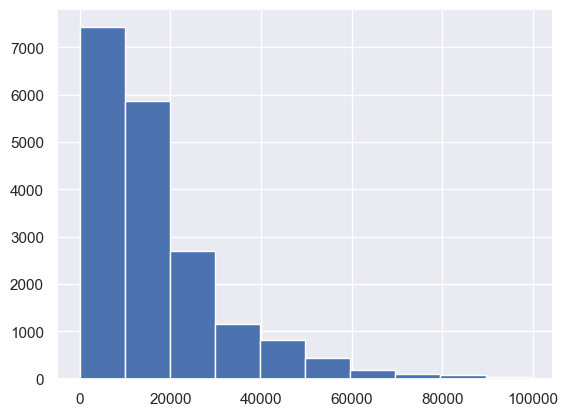

In [40]:
plt.hist(price_selected['Price'])
plt.show()

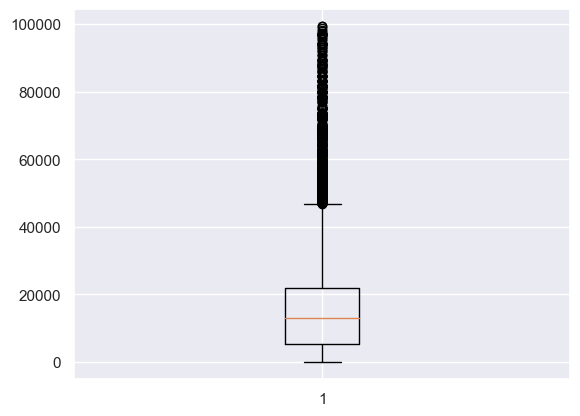

In [41]:
plt.boxplot(price_selected['Price'])
plt.show()

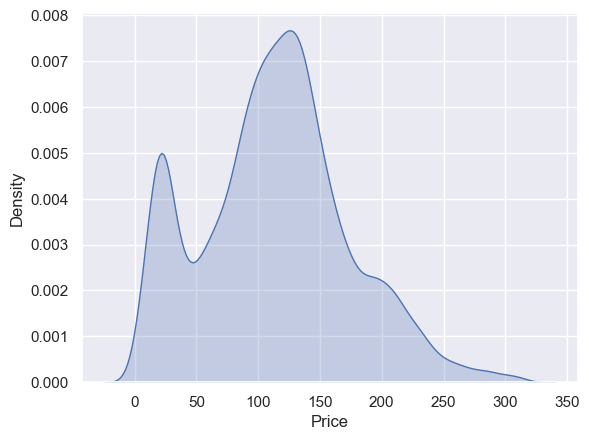

In [42]:
sns.kdeplot(np.sqrt(price_selected['Price']), fill=True)
plt.show()

#### Define class to calculate IQR

In [43]:
class IQR:
    def __init__(self, feature, data):
        self.feature = feature
        self.data = data

    def calculate_iqr(self):
        q1 = np.percentile(self.data[self.feature], 25)
        q3 = np.percentile(self.data[self.feature], 75)
        iqr = q3 - q1
        lower_limit = q1 - 1.5 * iqr
        upper_limit = q3 + 1.5 * iqr
        self.outliers = self.data[((self.data[self.feature] < lower_limit) | (self.data[self.feature] > upper_limit))]
        return  {
            'q1': q1,
            'q3': q3,
            'iqr': iqr,
            'lower_limit': lower_limit,
            'upper_limit': upper_limit
        }
        

In [44]:
numerical_data.columns

Index(['Price', 'Levy', 'Engine volume', 'Mileage', 'Cylinders', 'Airbags',
       'age'],
      dtype='object')

#### Levy Outliers

In [45]:
Levy_iqr = IQR('Levy', price_selected)

In [46]:
Levy_iqr.calculate_iqr()

{'q1': 0.0,
 'q3': 915.0,
 'iqr': 915.0,
 'lower_limit': -1372.5,
 'upper_limit': 2287.5}

In [47]:
Levy_iqr.outliers

,index,Price,Levy,Engine volume,Mileage,Cylinders,Airbags,age
18,18,549,2386,3.3,295059.0,6.0,12,17
26,26,549,2455,4.7,0.0,8.0,0,15
78,78,862,2455,4.7,263190.0,8.0,0,15
115,115,11917,11714,5.0,150000.0,12.0,12,20
132,132,549,2866,3.5,299709.0,6.0,12,19
...,...,...,...,...,...,...,...,...
18440,18550,282,2455,4.7,218126.0,8.0,0,15
18539,18650,14740,11706,5.0,56000.0,12.0,12,18
18545,18656,33,2308,3.7,185000.0,5.0,12,16
18564,18675,11917,11714,5.0,150000.0,12.0,12,20


In [48]:
Levy_iqr.outliers['Price'].values

array([  549,   549,   862, 11917,   549,   862,   282, 35438,   862,
         282, 11290,  9565, 27911, 28225, 35752,   314,  9095,  7840,
        3136,   314,   282,   314, 47042, 10349,  3150, 10036,  5331,
         282,   282,   392, 17249,  6272, 14740, 12000, 83251, 18000,
         862, 17562,   549, 14113, 20385, 13172,   862,   282,   862,
         314, 45000, 11760,   314,  7840,  5645, 25089, 26657,   282,
         314,   549, 58018, 28225,   314,   862,   862,   314,   392,
         314,   282, 11290,   862,  9400,   549, 72130, 12544, 28539,
       25089,   784, 10000,   627, 31988,   862,   627, 22266,  1254,
         392,   282,   862,   314,   282,   314,  8500,  2000,  6272,
         862,   282, 18000, 31675,   862, 31361,   282,   314, 18817,
         314,   862, 10506, 14113,   314, 56450, 28222,   941, 11290,
        9722,   549,  2744,   282,   627, 64290,   862, 35124,   314,
        7997,   862,   862,  7840, 13172, 17876, 10976, 17249,  6272,
       32302,  7840,

In [49]:
Levy_iqr.outliers.index

Index([   18,    26,    78,   115,   132,   490,   508,   698,   872,   926,
       ...
       17399, 17484, 18084, 18138, 18357, 18440, 18539, 18545, 18564, 18628],
      dtype='int64', length=156)

In [50]:
Levy_selected = price_selected.iloc[~price_selected.index.isin(Levy_iqr.outliers.index)]

In [51]:
Levy_selected

,index,Price,Levy,Engine volume,Mileage,Cylinders,Airbags,age
0,0,13328,1399,3.5,186005.0,6.0,12,13
1,1,16621,1018,3.0,192000.0,6.0,8,12
2,2,8467,0,1.3,200000.0,4.0,2,17
3,3,3607,862,2.5,168966.0,4.0,0,12
4,4,11726,446,1.3,91901.0,4.0,4,9
...,...,...,...,...,...,...,...,...
18808,18919,8467,0,2.0,300000.0,4.0,5,24
18809,18920,15681,831,2.4,161600.0,4.0,8,12
18810,18921,26108,836,2.0,116365.0,4.0,4,13
18811,18922,5331,1288,2.0,51258.0,4.0,4,16


In [52]:
len(Levy_selected)

18657

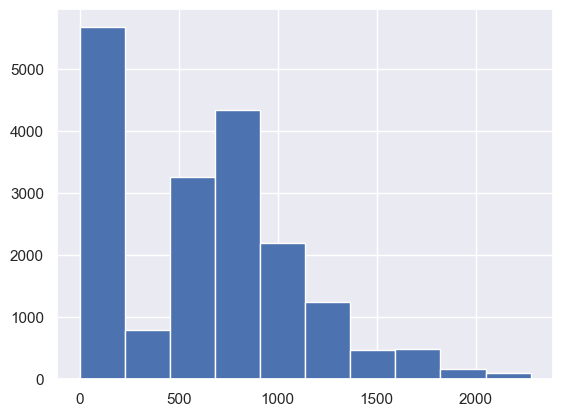

In [53]:
plt.hist(Levy_selected['Levy'])
plt.show()

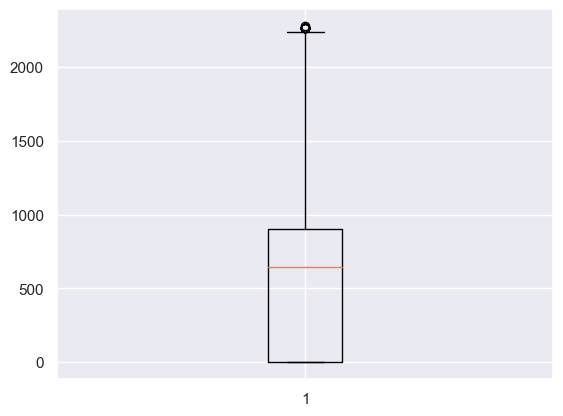

In [54]:
plt.boxplot(Levy_selected['Levy'])
plt.show()

In [55]:
numerical_data.columns

Index(['Price', 'Levy', 'Engine volume', 'Mileage', 'Cylinders', 'Airbags',
       'age'],
      dtype='object')

#### Mileage Outliers

In [56]:
Mileage_iqr = IQR('Mileage', Levy_selected)

In [57]:
Mileage_iqr.calculate_iqr()

{'q1': 70994.0,
 'q3': 189000.0,
 'iqr': 118006.0,
 'lower_limit': -106015.0,
 'upper_limit': 366009.0}

In [58]:
Mileage_iqr.outliers

,index,Price,Levy,Engine volume,Mileage,Cylinders,Airbags,age
8,8,1098,394,2.5,3.980690e+05,4.0,12,9
29,29,12074,1537,3.3,4.205500e+05,6.0,12,14
39,39,314,1399,3.5,3.827460e+05,6.0,12,13
65,65,9722,765,2.0,7.198470e+05,4.0,4,8
90,90,77775,1604,5.5,4.338110e+05,8.0,10,9
...,...,...,...,...,...,...,...,...
18742,18853,5018,645,1.8,4.895840e+05,4.0,12,12
18746,18857,18817,1995,2.4,2.147484e+09,4.0,2,20
18773,18884,500,0,2.5,7.600000e+05,4.0,2,25
18778,18889,3763,0,1.8,1.111111e+09,5.0,2,28


In [59]:
Mileage_iqr.outliers.describe()['Mileage']

count    6.410000e+02
mean     4.222611e+07
std      2.621143e+08
min      3.668690e+05
25%      3.980690e+05
50%      4.568670e+05
75%      5.954260e+05
max      2.147484e+09
Name: Mileage, dtype: float64

In [60]:
Mileage_selected = Levy_selected[Levy_selected['Mileage']<600000]

In [61]:
Mileage_selected

,index,Price,Levy,Engine volume,Mileage,Cylinders,Airbags,age
0,0,13328,1399,3.5,186005.0,6.0,12,13
1,1,16621,1018,3.0,192000.0,6.0,8,12
2,2,8467,0,1.3,200000.0,4.0,2,17
3,3,3607,862,2.5,168966.0,4.0,0,12
4,4,11726,446,1.3,91901.0,4.0,4,9
...,...,...,...,...,...,...,...,...
18808,18919,8467,0,2.0,300000.0,4.0,5,24
18809,18920,15681,831,2.4,161600.0,4.0,8,12
18810,18921,26108,836,2.0,116365.0,4.0,4,13
18811,18922,5331,1288,2.0,51258.0,4.0,4,16


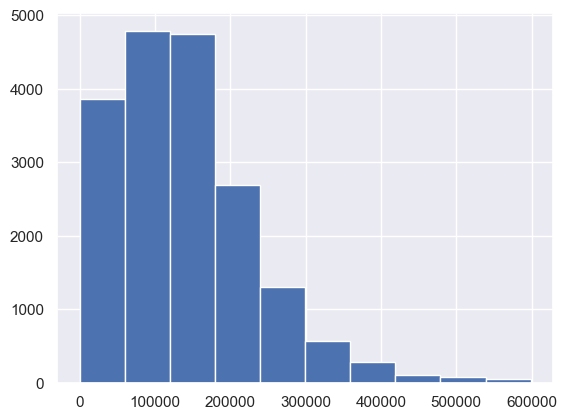

In [62]:
plt.hist(Mileage_selected['Mileage'])
plt.show()

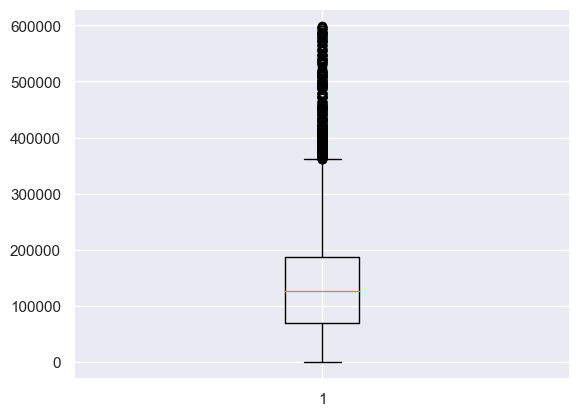

In [63]:
plt.boxplot(Mileage_selected['Mileage'])
plt.show()

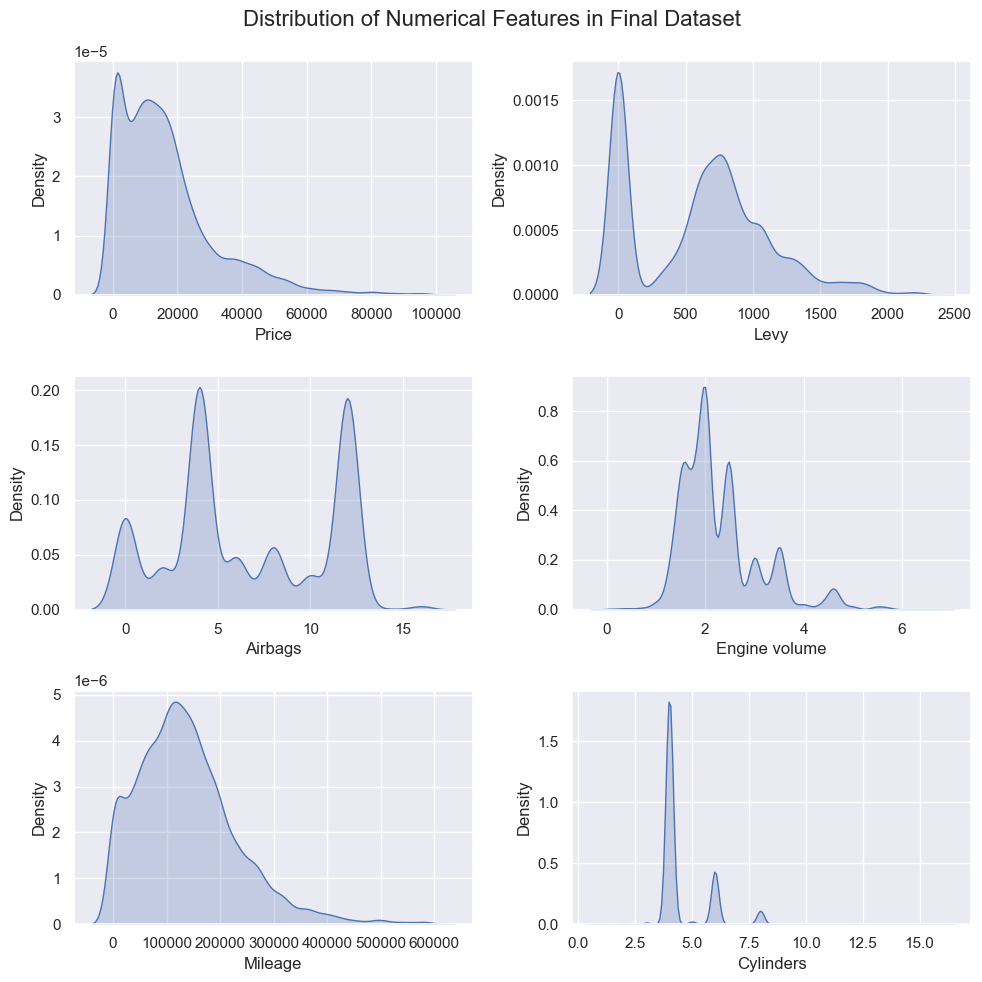

In [64]:
fig, axes = plt.subplots(3,2, figsize=(10, 10))

sns.kdeplot(Mileage_selected['Price'], fill=True, ax=axes[0,0])
sns.kdeplot(Mileage_selected['Levy'], fill=True, ax=axes[0,1])
sns.kdeplot(Mileage_selected['Airbags'], fill=True, ax=axes[1,0])
sns.kdeplot(Mileage_selected['Engine volume'], fill=True, ax=axes[1,1])
sns.kdeplot(Mileage_selected['Mileage'], fill=True, ax=axes[2,0])
sns.kdeplot(Mileage_selected['Cylinders'], fill=True, ax=axes[2,1])

fig.suptitle('Distribution of Numerical Features in Final Dataset', fontsize=16)
plt.tight_layout()
plt.show()

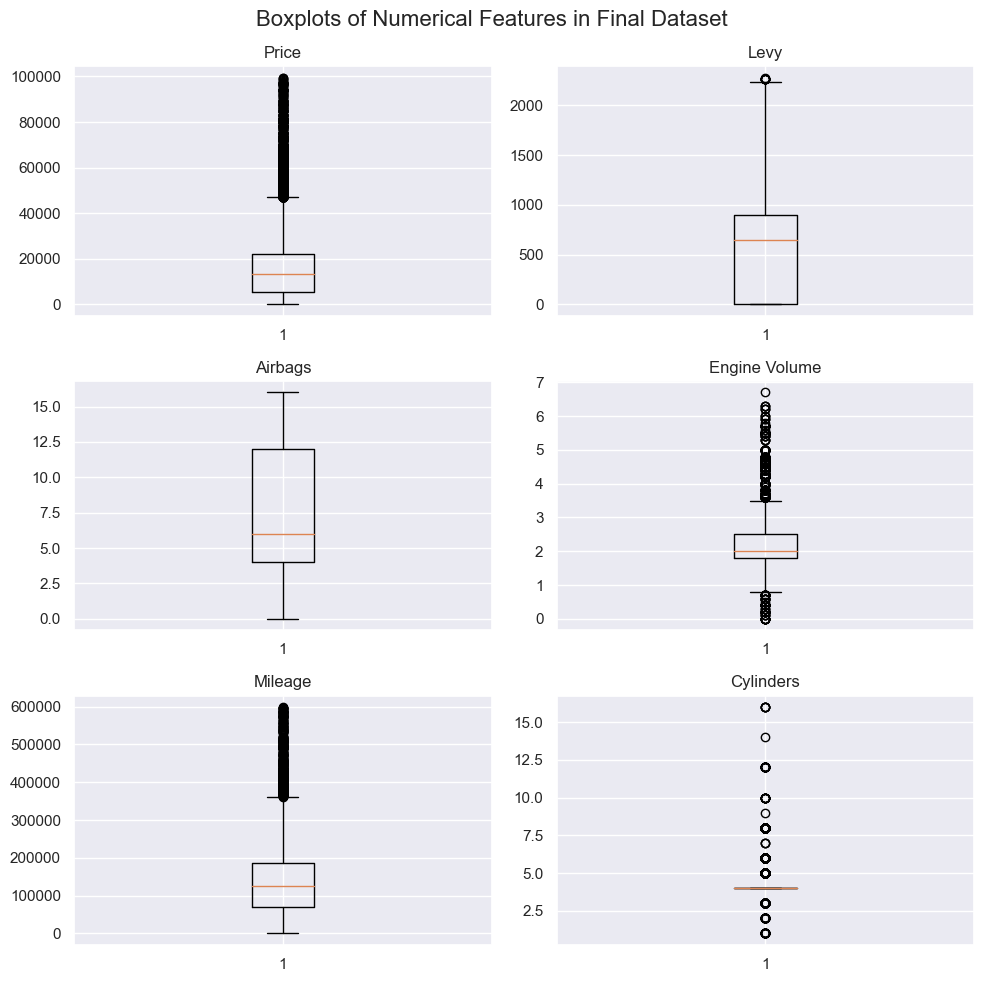

In [65]:
fig, axes = plt.subplots(3,2, figsize=(10, 10))

axes[0,0].boxplot(Mileage_selected['Price'])
axes[0,1].boxplot(Mileage_selected['Levy'])
axes[1,0].boxplot(Mileage_selected['Airbags'])
axes[1,1].boxplot(Mileage_selected['Engine volume'])
axes[2,0].boxplot(Mileage_selected['Mileage'])
axes[2,1].boxplot(Mileage_selected['Cylinders'])

axes[0, 0].set_title('Price')
axes[0, 1].set_title('Levy')
axes[1, 0].set_title('Airbags')
axes[1, 1].set_title('Engine Volume')
axes[2, 0].set_title('Mileage')
axes[2, 1].set_title('Cylinders')

plt.suptitle('Boxplots of Numerical Features in Final Dataset', fontsize=16)
plt.tight_layout()
plt.show()

* <font color = 'brown'>**All distributions looks better after outlier removal**</font>

In [66]:
numerical_selected = Mileage_selected.reset_index(drop=True)

In [67]:
numerical_selected

,index,Price,Levy,Engine volume,Mileage,Cylinders,Airbags,age
0,0,13328,1399,3.5,186005.0,6.0,12,13
1,1,16621,1018,3.0,192000.0,6.0,8,12
2,2,8467,0,1.3,200000.0,4.0,2,17
3,3,3607,862,2.5,168966.0,4.0,0,12
4,4,11726,446,1.3,91901.0,4.0,4,9
...,...,...,...,...,...,...,...,...
18496,18919,8467,0,2.0,300000.0,4.0,5,24
18497,18920,15681,831,2.4,161600.0,4.0,8,12
18498,18921,26108,836,2.0,116365.0,4.0,4,13
18499,18922,5331,1288,2.0,51258.0,4.0,4,16


In [68]:
numerical_selected['index'].values

array([    0,     1,     2, ..., 18921, 18922, 18923], dtype=int64)

In [69]:
categorical_data = categorical_data.iloc[numerical_selected['index'].values]

In [70]:
categorical_data = categorical_data.reset_index(drop=True)

In [71]:
categorical_data

,Manufacturer,Model,Category,Leather interior,Fuel type,Gear box type,Drive wheels,Doors,Wheel,Color
0,LEXUS,RX 450,Jeep,Yes,Hybrid,Automatic,4x4,4,Left wheel,Silver
1,CHEVROLET,Equinox,Jeep,No,Petrol,Tiptronic,4x4,4,Left wheel,Black
2,HONDA,FIT,Hatchback,No,Petrol,Variator,Front,4,Right-hand drive,Black
3,FORD,Escape,Jeep,Yes,Hybrid,Automatic,4x4,4,Left wheel,White
4,HONDA,FIT,Hatchback,Yes,Petrol,Automatic,Front,4,Left wheel,Silver
...,...,...,...,...,...,...,...,...,...,...
18496,MERCEDES-BENZ,CLK 200,Coupe,Yes,CNG,Manual,Rear,2,Left wheel,Silver
18497,HYUNDAI,Sonata,Sedan,Yes,Petrol,Tiptronic,Front,4,Left wheel,Red
18498,HYUNDAI,Tucson,Jeep,Yes,Diesel,Automatic,Front,4,Left wheel,Grey
18499,CHEVROLET,Captiva,Jeep,Yes,Diesel,Automatic,Front,4,Left wheel,Black


In [72]:
df2 = pd.concat([numerical_selected, categorical_data], axis=1)
df2.head()

,index,Price,Levy,Engine volume,Mileage,Cylinders,Airbags,age,Manufacturer,Model,Category,Leather interior,Fuel type,Gear box type,Drive wheels,Doors,Wheel,Color
0,0,13328,1399,3.5,186005.0,6.0,12,13,LEXUS,RX 450,Jeep,Yes,Hybrid,Automatic,4x4,4,Left wheel,Silver
1,1,16621,1018,3.0,192000.0,6.0,8,12,CHEVROLET,Equinox,Jeep,No,Petrol,Tiptronic,4x4,4,Left wheel,Black
2,2,8467,0,1.3,200000.0,4.0,2,17,HONDA,FIT,Hatchback,No,Petrol,Variator,Front,4,Right-hand drive,Black
3,3,3607,862,2.5,168966.0,4.0,0,12,FORD,Escape,Jeep,Yes,Hybrid,Automatic,4x4,4,Left wheel,White
4,4,11726,446,1.3,91901.0,4.0,4,9,HONDA,FIT,Hatchback,Yes,Petrol,Automatic,Front,4,Left wheel,Silver


In [73]:
df2.shape

(18501, 18)

## Handling Catogorical variables

In [74]:
categorical_data

,Manufacturer,Model,Category,Leather interior,Fuel type,Gear box type,Drive wheels,Doors,Wheel,Color
0,LEXUS,RX 450,Jeep,Yes,Hybrid,Automatic,4x4,4,Left wheel,Silver
1,CHEVROLET,Equinox,Jeep,No,Petrol,Tiptronic,4x4,4,Left wheel,Black
2,HONDA,FIT,Hatchback,No,Petrol,Variator,Front,4,Right-hand drive,Black
3,FORD,Escape,Jeep,Yes,Hybrid,Automatic,4x4,4,Left wheel,White
4,HONDA,FIT,Hatchback,Yes,Petrol,Automatic,Front,4,Left wheel,Silver
...,...,...,...,...,...,...,...,...,...,...
18496,MERCEDES-BENZ,CLK 200,Coupe,Yes,CNG,Manual,Rear,2,Left wheel,Silver
18497,HYUNDAI,Sonata,Sedan,Yes,Petrol,Tiptronic,Front,4,Left wheel,Red
18498,HYUNDAI,Tucson,Jeep,Yes,Diesel,Automatic,Front,4,Left wheel,Grey
18499,CHEVROLET,Captiva,Jeep,Yes,Diesel,Automatic,Front,4,Left wheel,Black


### Manufacturer

In [75]:
manufacturer_df = categorical_data['Manufacturer'].value_counts().to_frame()
manufacturer_df['percentage'] = np.round((manufacturer_df['count']/sum(manufacturer_df['count']))*100, 2)
manufacturer_df

,count,percentage
Manufacturer,,
HYUNDAI,3664,19.80
TOYOTA,3564,19.26
MERCEDES-BENZ,1956,10.57
FORD,1061,5.73
CHEVROLET,1040,5.62
...,...,...
TESLA,1,0.01
PONTIAC,1,0.01
SATURN,1,0.01


In [76]:
manufacturer_df[manufacturer_df['percentage']>1]

,count,percentage
Manufacturer,,
HYUNDAI,3664,19.80
TOYOTA,3564,19.26
MERCEDES-BENZ,1956,10.57
FORD,1061,5.73
CHEVROLET,1040,5.62
BMW,1002,5.42
HONDA,950,5.13
LEXUS,876,4.73
NISSAN,638,3.45


In [77]:
other_manufactures = manufacturer_df[manufacturer_df['percentage']<5]
other_manufactures

,count,percentage
Manufacturer,,
LEXUS,876,4.73
NISSAN,638,3.45
VOLKSWAGEN,565,3.05
SSANGYONG,439,2.37
KIA,415,2.24
OPEL,381,2.06
MITSUBISHI,283,1.53
SUBARU,270,1.46
AUDI,251,1.36


In [78]:
other_manufactures.index

Index(['LEXUS', 'NISSAN', 'VOLKSWAGEN', 'SSANGYONG', 'KIA', 'OPEL',
       'MITSUBISHI', 'SUBARU', 'AUDI', 'MAZDA', 'JEEP', 'DAEWOO', 'DODGE',
       'FIAT', 'SUZUKI', 'MINI', 'VAZ', 'PORSCHE', 'LAND ROVER', 'RENAULT',
       'JAGUAR', 'INFINITI', 'CHRYSLER', 'SKODA', 'VOLVO', 'PEUGEOT', 'BUICK',
       'ACURA', 'LINCOLN', 'CADILLAC', 'DAIHATSU', 'GAZ', 'GMC', 'UAZ',
       'CITROEN', 'SCION', 'MASERATI', 'ISUZU', 'ALFA ROMEO', 'HUMMER',
       'MERCURY', 'ROVER', 'MOSKVICH', 'SAAB', 'ROLLS-ROYCE', 'სხვა', 'SEAT',
       'ZAZ', 'LANCIA', 'HAVAL', 'TESLA', 'PONTIAC', 'SATURN', 'ASTON MARTIN',
       'GREATWALL'],
      dtype='object', name='Manufacturer')

In [79]:
df2.pivot_table(values='Price', index='Manufacturer', aggfunc='mean').loc[other_manufactures.index]

,Price
Manufacturer,
LEXUS,19576.750000
NISSAN,9870.739812
VOLKSWAGEN,11546.658407
SSANGYONG,30921.858770
KIA,15222.221687
OPEL,6894.456693
MITSUBISHI,12926.484099
SUBARU,10048.544444
AUDI,13319.984064


In [80]:
categorical_data = categorical_data[~categorical_data['Manufacturer'].isin(other_manufactures.index)]
len(categorical_data)

13237

### Model

In [81]:
model_df = categorical_data['Model'].value_counts().to_frame()
model_df['percentage'] = np.round((model_df['count']/sum(model_df['count']))*100, 2)
model_df

,count,percentage
Model,,
Prius,1059,8.00
Sonata,1013,7.65
Camry,927,7.00
Elantra,905,6.84
Santa FE,522,3.94
...,...,...
C 200 KOMPRESSOR,1,0.01
Civic Ferio,1,0.01
ML 270 CDI,1,0.01


In [82]:
other_models = model_df[model_df['percentage']<1]
other_models

,count,percentage
Model,,
Prius C,117,0.88
Insight,115,0.87
Genesis,105,0.79
Orlando,100,0.76
Malibu,88,0.66
...,...,...
C 200 KOMPRESSOR,1,0.01
Civic Ferio,1,0.01
ML 270 CDI,1,0.01


In [83]:
categorical_data = categorical_data[~categorical_data['Model'].isin(other_models.index)]
len(categorical_data)

8880

In [84]:
category_df = categorical_data['Category'].value_counts().to_frame()
category_df['percentage'] = np.round((category_df['count']/sum(category_df['count']))*100, 2)
category_df

,count,percentage
Category,,
Sedan,4562,51.37
Jeep,2163,24.36
Hatchback,1407,15.84
Minivan,283,3.19
Universal,186,2.09
Microbus,168,1.89
Coupe,73,0.82
Goods wagon,35,0.39
Pickup,2,0.02


In [85]:
other_category = category_df[category_df['percentage']<1]
other_category

,count,percentage
Category,,
Coupe,73,0.82
Goods wagon,35,0.39
Pickup,2,0.02
Cabriolet,1,0.01


In [86]:
categorical_data = categorical_data[~categorical_data['Category'].isin(other_category.index)]
len(categorical_data)

8769

In [87]:
categorical_data.columns

Index(['Manufacturer', 'Model', 'Category', 'Leather interior', 'Fuel type',
       'Gear box type', 'Drive wheels', 'Doors', 'Wheel', 'Color'],
      dtype='object')

### Fuel type

In [88]:
fuel_df = categorical_data['Fuel type'].value_counts().to_frame()
fuel_df['percentage'] = np.round((fuel_df['count']/sum(category_df['count']))*100, 2)
fuel_df

,count,percentage
Fuel type,,
Petrol,3146,35.43
Hybrid,2564,28.87
Diesel,2378,26.78
LPG,592,6.67
Plug-in Hybrid,59,0.66
CNG,30,0.34


In [89]:
categorical_data = categorical_data[~(categorical_data['Fuel type']=='Plug-in Hybrid')]

In [90]:
len(categorical_data)

8710

### Interior

In [91]:
interior_df = categorical_data['Leather interior'].value_counts().to_frame()
interior_df['percentage'] = np.round((interior_df['count']/sum(category_df['count']))*100, 2)
interior_df

,count,percentage
Leather interior,,
Yes,6884,77.52
No,1826,20.56


### Gearbox type

In [92]:
gearbox_df = categorical_data['Gear box type'].value_counts().to_frame()
gearbox_df['percentage'] = np.round((gearbox_df['count']/sum(category_df['count']))*100, 2)
gearbox_df

,count,percentage
Gear box type,,
Automatic,7157,80.60
Tiptronic,891,10.03
Variator,441,4.97
Manual,221,2.49


### Drive wheels

In [93]:
drivewheel_df = categorical_data['Drive wheels'].value_counts().to_frame()
drivewheel_df['percentage'] = np.round((drivewheel_df['count']/sum(category_df['count']))*100, 2)
drivewheel_df

,count,percentage
Drive wheels,,
Front,7071,79.63
4x4,1258,14.17
Rear,381,4.29


### Doors

In [94]:
doors_df = categorical_data['Doors'].value_counts().to_frame()
doors_df['percentage'] = np.round((doors_df['count']/sum(category_df['count']))*100, 2)
doors_df

,count,percentage
Doors,,
4,8608,96.94
2,63,0.71
>5,39,0.44


In [95]:
categorical_data = categorical_data[~(categorical_data['Doors']=='>5')]

In [96]:
len(categorical_data)

8671

### Wheels

In [97]:
wheel_df = categorical_data['Wheel'].value_counts().to_frame()
wheel_df['percentage'] = np.round((wheel_df['count']/sum(category_df['count']))*100, 2)
wheel_df

,count,percentage
Wheel,,
Left wheel,8200,92.34
Right-hand drive,471,5.30


### Color

In [98]:
color_df = categorical_data['Color'].value_counts().to_frame()
color_df['percentage'] = np.round((color_df['count']/sum(category_df['count']))*100, 2)
color_df

,count,percentage
Color,,
White,2160,24.32
Black,2027,22.83
Silver,1802,20.29
Grey,1242,13.99
Blue,582,6.55
Red,225,2.53
Orange,183,2.06
Green,97,1.09
Brown,86,0.97


In [99]:
categorical_data = categorical_data.reset_index()
categorical_data

,index,Manufacturer,Model,Category,Leather interior,Fuel type,Gear box type,Drive wheels,Doors,Wheel,Color
0,2,HONDA,FIT,Hatchback,No,Petrol,Variator,Front,4,Right-hand drive,Black
1,3,FORD,Escape,Jeep,Yes,Hybrid,Automatic,4x4,4,Left wheel,White
2,4,HONDA,FIT,Hatchback,Yes,Petrol,Automatic,Front,4,Left wheel,Silver
3,5,HYUNDAI,Santa FE,Jeep,Yes,Diesel,Automatic,Front,4,Left wheel,White
4,6,TOYOTA,Prius,Hatchback,Yes,Hybrid,Automatic,Front,4,Left wheel,White
...,...,...,...,...,...,...,...,...,...,...,...
8666,18495,MERCEDES-BENZ,E 350,Sedan,Yes,Diesel,Automatic,Rear,4,Left wheel,Grey
8667,18497,HYUNDAI,Sonata,Sedan,Yes,Petrol,Tiptronic,Front,4,Left wheel,Red
8668,18498,HYUNDAI,Tucson,Jeep,Yes,Diesel,Automatic,Front,4,Left wheel,Grey
8669,18499,CHEVROLET,Captiva,Jeep,Yes,Diesel,Automatic,Front,4,Left wheel,Black


In [100]:
numerical_selected = numerical_selected.iloc[categorical_data['index'].values]

In [101]:
numerical_selected = numerical_selected.reset_index(drop=True)

In [102]:
numerical_selected

,index,Price,Levy,Engine volume,Mileage,Cylinders,Airbags,age
0,2,8467,0,1.3,200000.0,4.0,2,17
1,3,3607,862,2.5,168966.0,4.0,0,12
2,4,11726,446,1.3,91901.0,4.0,4,9
3,5,39493,891,2.0,160931.0,4.0,4,7
4,6,1803,761,1.8,258909.0,4.0,12,13
...,...,...,...,...,...,...,...,...
8666,18918,5802,1055,3.5,107800.0,6.0,12,10
8667,18920,15681,831,2.4,161600.0,4.0,8,12
8668,18921,26108,836,2.0,116365.0,4.0,4,13
8669,18922,5331,1288,2.0,51258.0,4.0,4,16


In [103]:
df3 = pd.concat([numerical_selected, categorical_data], axis=1)

In [104]:
df3.drop('index', axis=1, inplace=True)

In [105]:
df3.shape

(8671, 17)

In [106]:
df3.head()

,Price,Levy,Engine volume,Mileage,Cylinders,Airbags,age,Manufacturer,Model,Category,Leather interior,Fuel type,Gear box type,Drive wheels,Doors,Wheel,Color
0,8467,0,1.3,200000.0,4.0,2,17,HONDA,FIT,Hatchback,No,Petrol,Variator,Front,4,Right-hand drive,Black
1,3607,862,2.5,168966.0,4.0,0,12,FORD,Escape,Jeep,Yes,Hybrid,Automatic,4x4,4,Left wheel,White
2,11726,446,1.3,91901.0,4.0,4,9,HONDA,FIT,Hatchback,Yes,Petrol,Automatic,Front,4,Left wheel,Silver
3,39493,891,2.0,160931.0,4.0,4,7,HYUNDAI,Santa FE,Jeep,Yes,Diesel,Automatic,Front,4,Left wheel,White
4,1803,761,1.8,258909.0,4.0,12,13,TOYOTA,Prius,Hatchback,Yes,Hybrid,Automatic,Front,4,Left wheel,White


### Visualize the categorical variables after handling

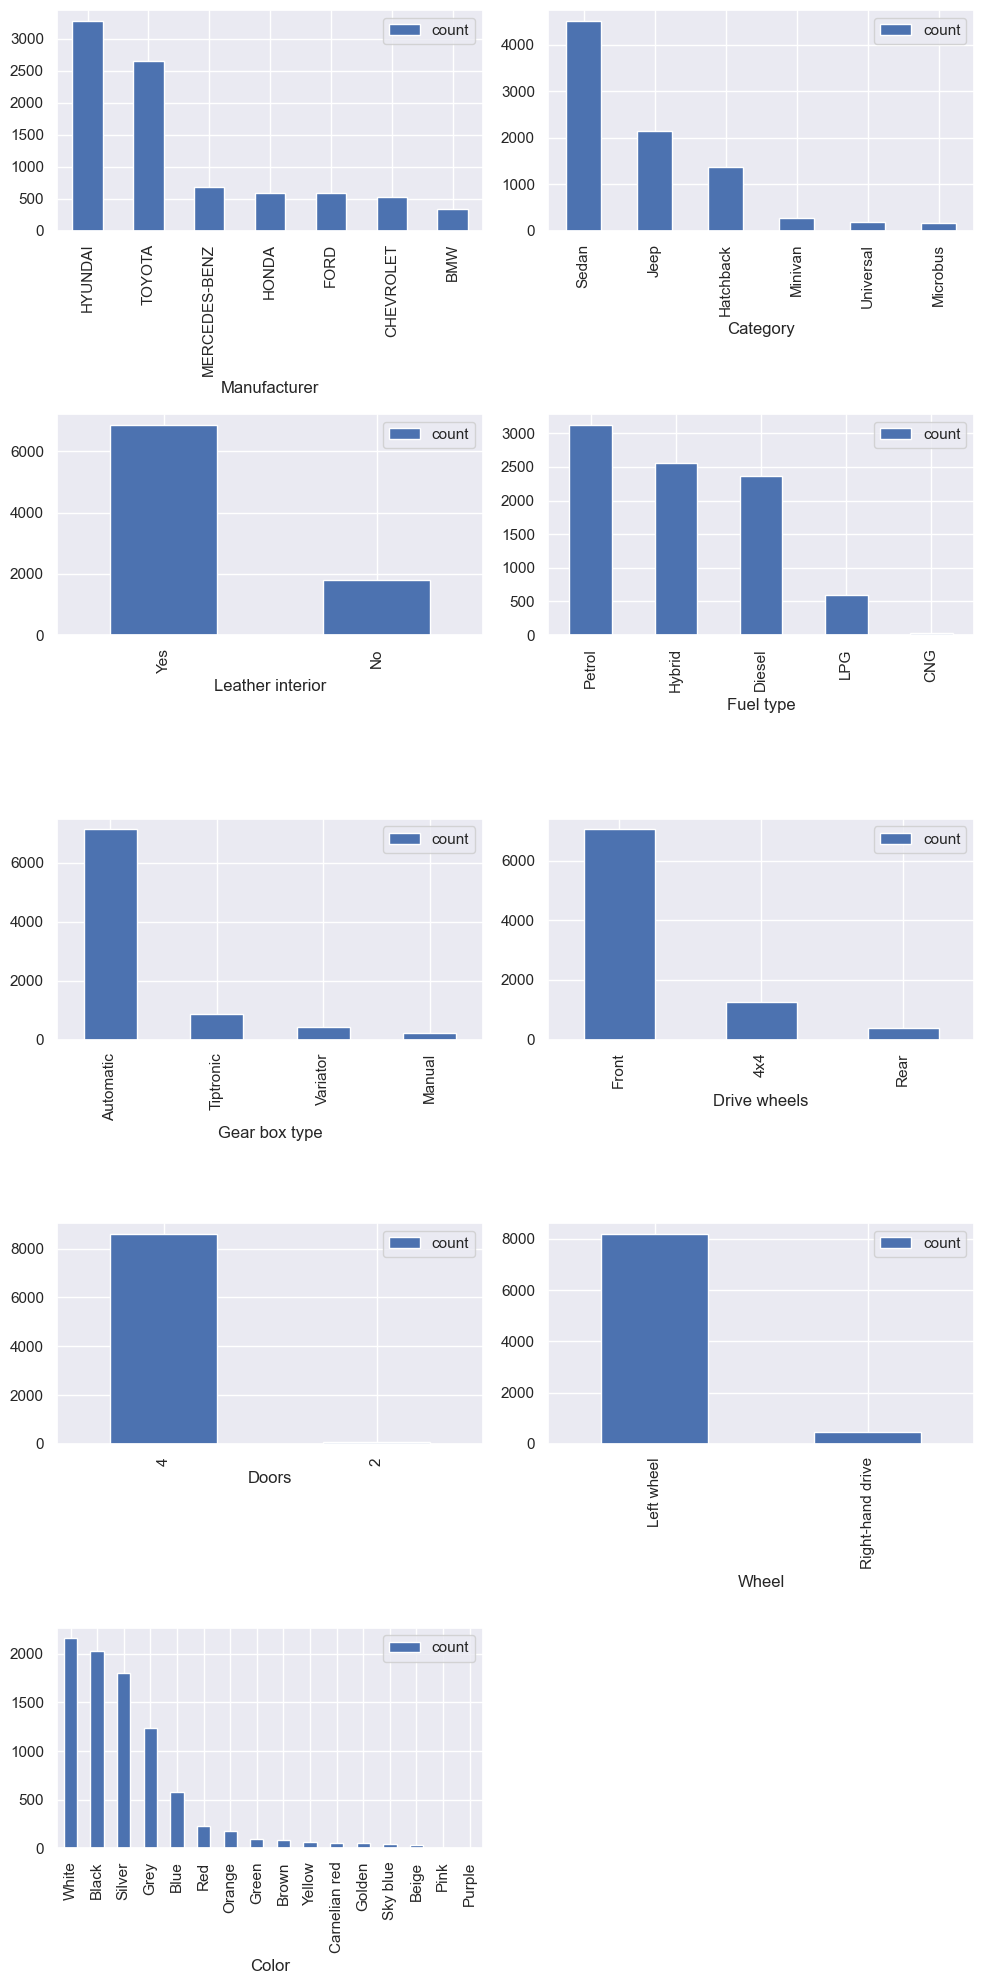

In [107]:
fig = plt.figure(figsize=(10,20))

ax1 = plt.subplot(5,2,1)
categorical_data['Manufacturer'].value_counts().to_frame().plot(kind = 'bar', ax=ax1)

ax2 = plt.subplot(5,2,2)
categorical_data['Category'].value_counts().to_frame().plot(kind = 'bar', ax=ax2)

ax3 = plt.subplot(5,2,3)
categorical_data['Leather interior'].value_counts().to_frame().plot(kind = 'bar', ax=ax3)

ax4 = plt.subplot(5,2,4)
categorical_data['Fuel type'].value_counts().to_frame().plot(kind = 'bar', ax=ax4)

ax5 = plt.subplot(5,2,5)
categorical_data['Gear box type'].value_counts().to_frame().plot(kind = 'bar', ax=ax5)

ax6 = plt.subplot(5,2,6)
categorical_data['Drive wheels'].value_counts().to_frame().plot(kind = 'bar', ax=ax6)

ax7 = plt.subplot(5,2,7)
categorical_data['Doors'].value_counts().to_frame().plot(kind = 'bar', ax=ax7)

ax8 = plt.subplot(5,2,8)
categorical_data['Wheel'].value_counts().to_frame().plot(kind = 'bar', ax=ax8)

ax9 = plt.subplot(5,2,9)
categorical_data['Color'].value_counts().to_frame().plot(kind = 'bar',ax=ax9)


plt.tight_layout()
plt.show()

In [108]:
df3_categorical = list(df3.columns[df3.dtypes=='object'])
df3_categorical

['Manufacturer',
 'Model',
 'Category',
 'Leather interior',
 'Fuel type',
 'Gear box type',
 'Drive wheels',
 'Doors',
 'Wheel',
 'Color']

## Visualize the variation of price among categorical features

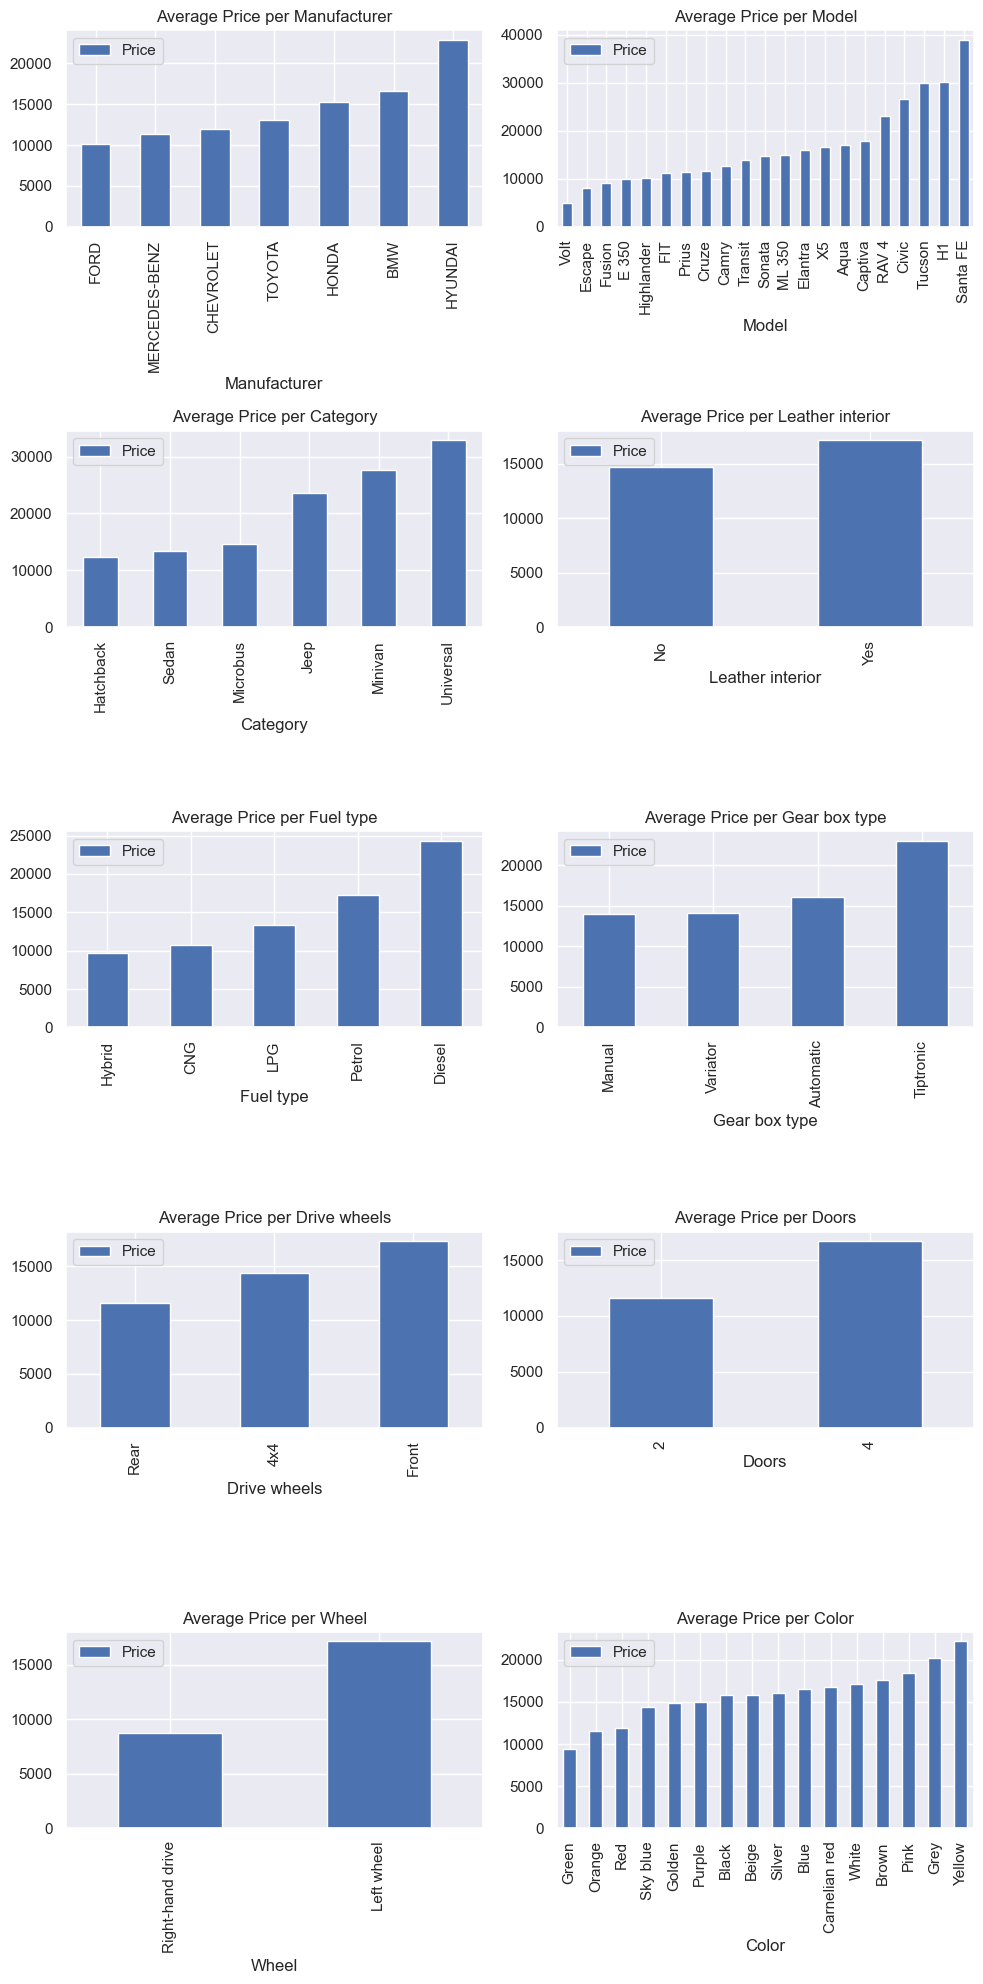

In [109]:
fig = plt.figure(figsize=(10,20))

for i in df3_categorical:
    ax = plt.subplot(5,2,df3_categorical.index(i)+1)
    df3.pivot_table(values='Price', index=i, aggfunc='mean').sort_values(by='Price').plot(kind='bar', ax=ax)
    plt.title('Average Price per {}'.format(i))
plt.tight_layout()
plt.show()

* <font color = 'brown'>**Looks like each categorical variable have a impact on price**</font>

In [110]:
df3_numerical = list(df3.columns[df3.dtypes!='object'])
df3_numerical

['Price', 'Levy', 'Engine volume', 'Mileage', 'Cylinders', 'Airbags', 'age']

## Visualize the variation of price with numerical features

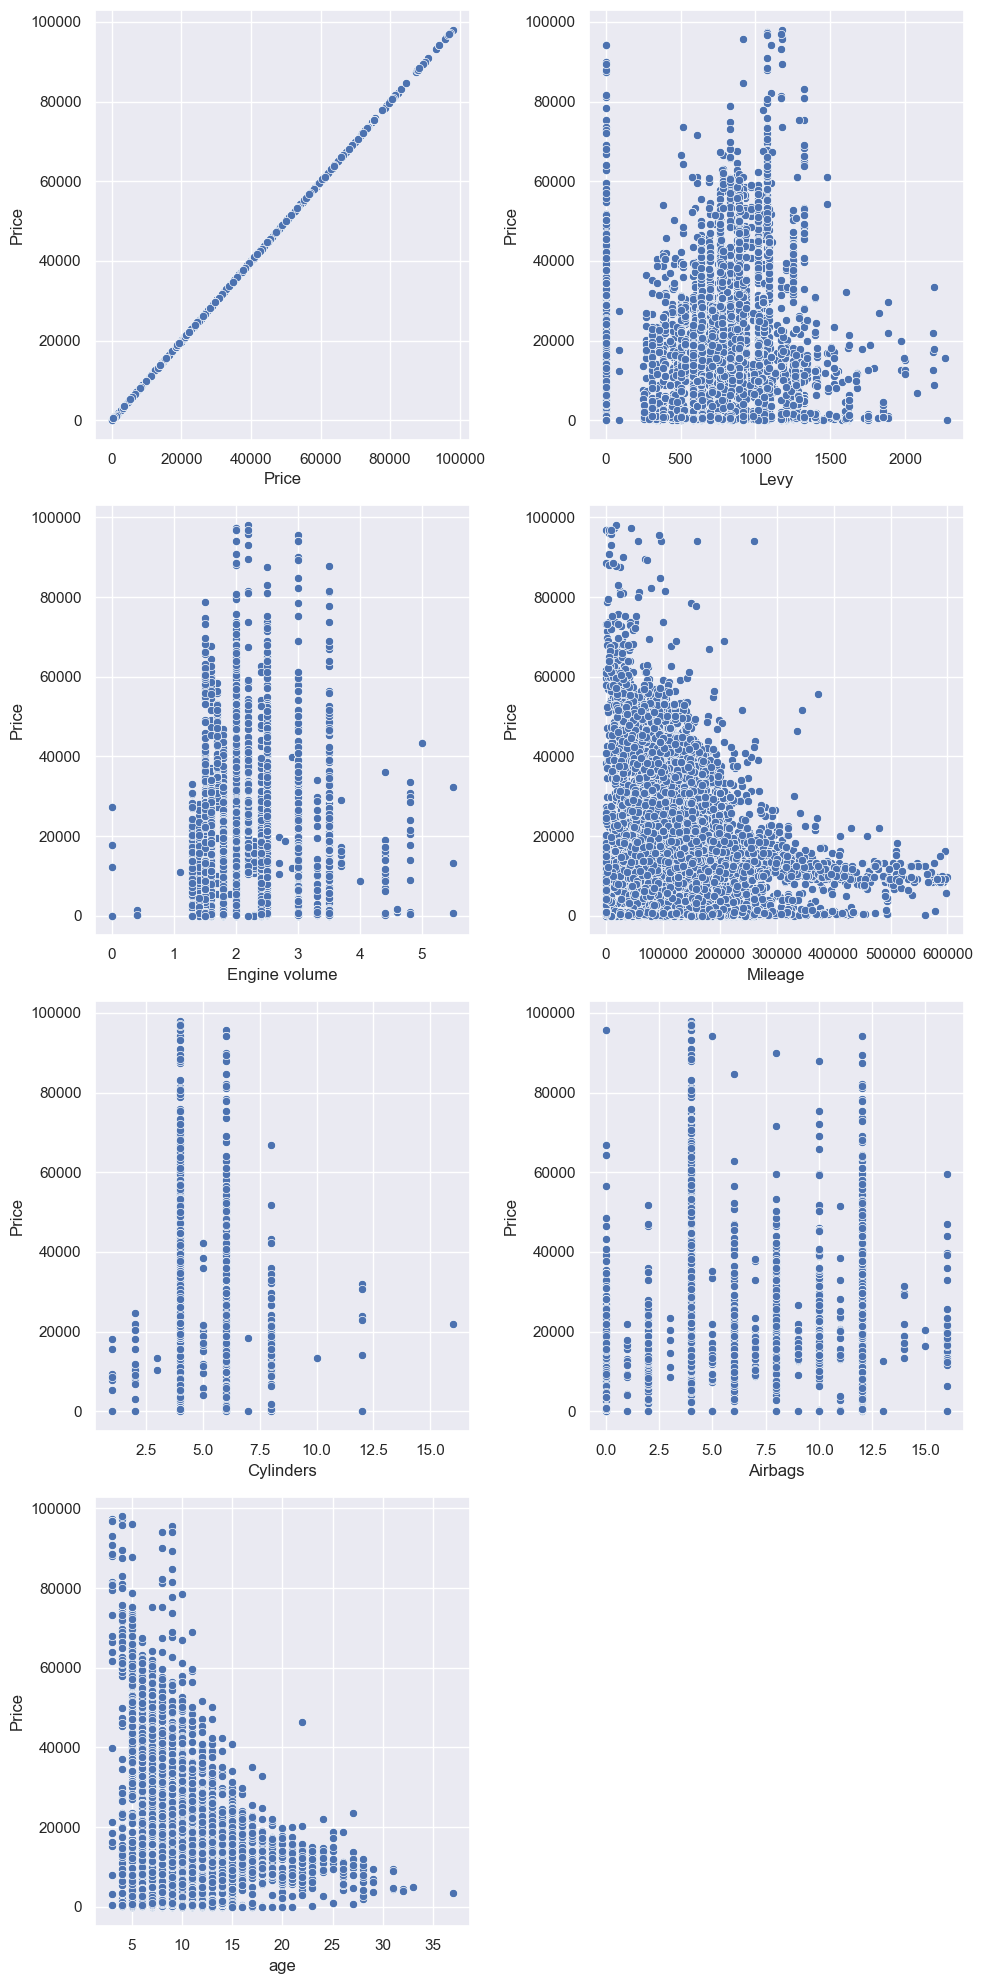

In [111]:
fig = plt.figure(figsize=(10,20))

for i in df3_numerical:
    ax = plt.subplot(4,2,df3_numerical.index(i)+1)
    sns.scatterplot(x=df3[i], y=df3['Price'], ax=ax)
    
plt.tight_layout()
plt.show()

* <font color = 'brown'>**Can not see any of feature linearly related with price**</font>

In [112]:
df3.head()

,Price,Levy,Engine volume,Mileage,Cylinders,Airbags,age,Manufacturer,Model,Category,Leather interior,Fuel type,Gear box type,Drive wheels,Doors,Wheel,Color
0,8467,0,1.3,200000.0,4.0,2,17,HONDA,FIT,Hatchback,No,Petrol,Variator,Front,4,Right-hand drive,Black
1,3607,862,2.5,168966.0,4.0,0,12,FORD,Escape,Jeep,Yes,Hybrid,Automatic,4x4,4,Left wheel,White
2,11726,446,1.3,91901.0,4.0,4,9,HONDA,FIT,Hatchback,Yes,Petrol,Automatic,Front,4,Left wheel,Silver
3,39493,891,2.0,160931.0,4.0,4,7,HYUNDAI,Santa FE,Jeep,Yes,Diesel,Automatic,Front,4,Left wheel,White
4,1803,761,1.8,258909.0,4.0,12,13,TOYOTA,Prius,Hatchback,Yes,Hybrid,Automatic,Front,4,Left wheel,White


In [113]:
X = df3.iloc[:,1:]
y = df3['Price']

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

## Handling highly correlated features

C:\Users\modhuka\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


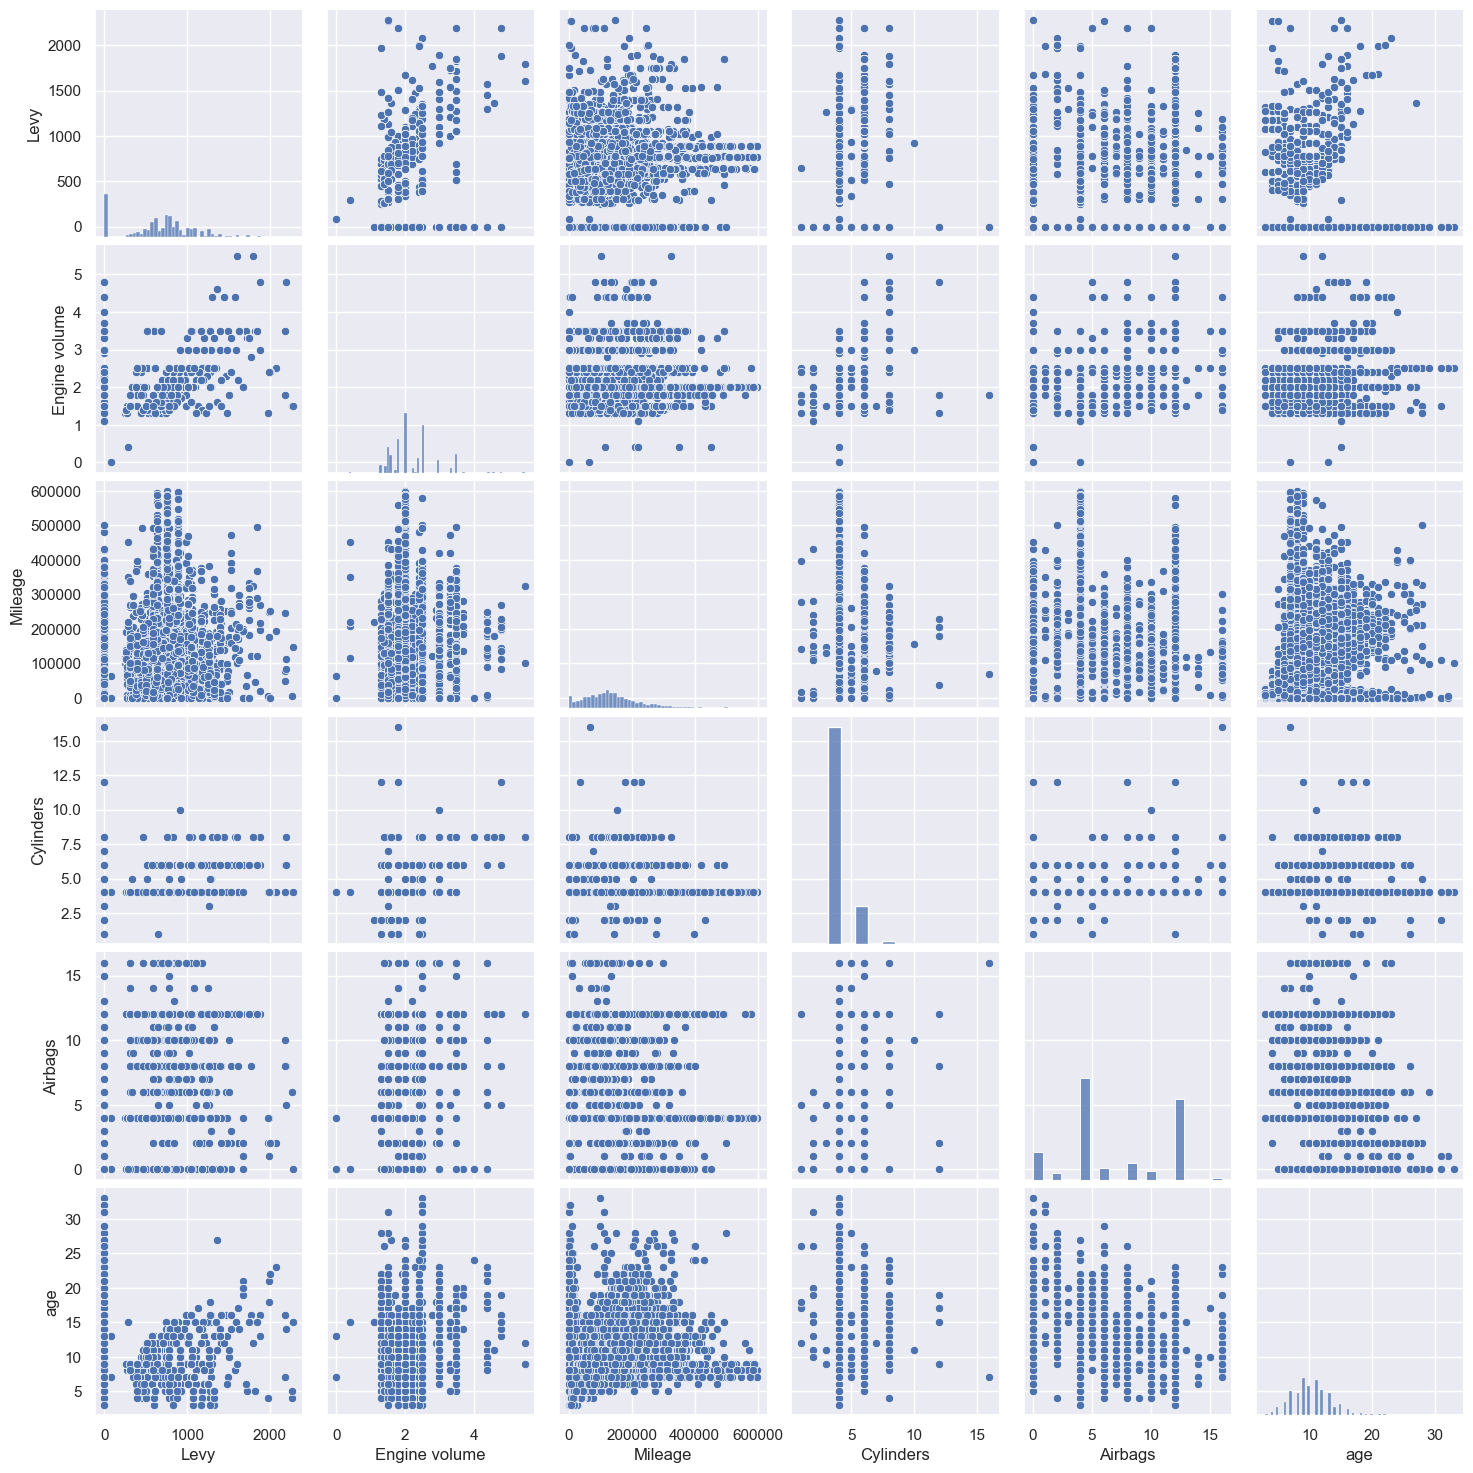

In [115]:
sns.pairplot(X_train)
plt.show()

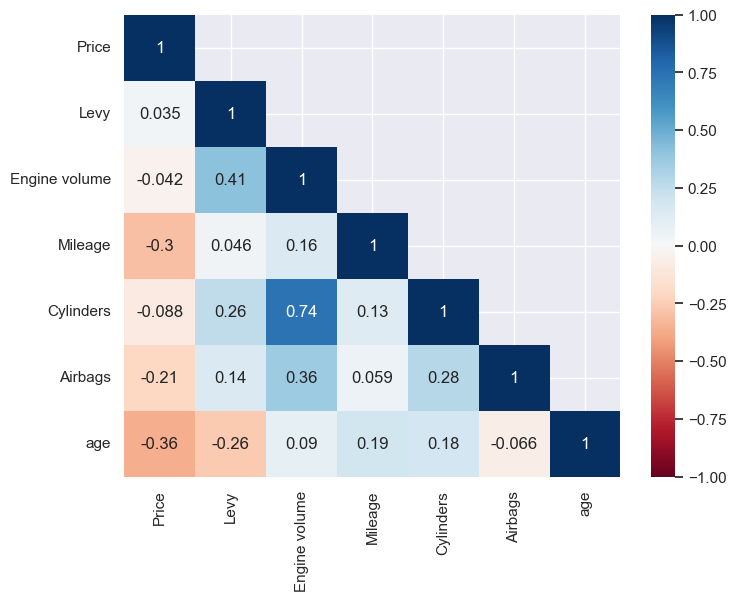

In [116]:
corr_matrix = df3.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool),k=1)
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix,annot=True,cmap='RdBu',vmin=-1,vmax=1,mask=mask)
plt.show()

* <font color ='brown'>**Engine volume and Cylinders show somewhat positive relationship.**</font>

## Check the significance of numerical features

In [117]:
x_numeric_train = X_train.select_dtypes('number')
x = sm.add_constant(x_numeric_train)
results = sm.OLS(y_train,x).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     381.7
Date:                Mon, 11 Dec 2023   Prob (F-statistic):               0.00
Time:                        11:16:23   Log-Likelihood:                -75542.
No. Observations:                6936   AIC:                         1.511e+05
Df Residuals:                    6929   BIC:                         1.511e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          3.904e+04    897.494     43.500      0.000    3.73e+04    4.08e+04
Levy             -2.7363      0.438     -6.249      0.000      -3.595      -1.878
Engine volume  3834.0943    396.656      9.666      0.000    3056.528    4611.661
Mileage          -0.0346      0.002    -22.226      0.000      -0.038      -0.032
Cylinders      -361.7607    273.386     -1.323      0.186    -897.681     174.159
Airbags        -916.2599     39.881    -22.975      0.000    -994.438    -838.082
age           -1522.2792     47.486    -32.057      0.000   -1615.367   -1429.191
==============================================================================
Omnibus:                      787.845   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1663.014
Skew:                           0.708   Prob(JB):                         0.00
Kurtosis:                       4.936   Cond. No.                     1.05e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

* <font color ='brown'>**Feature Cylinders is not significance**</font>

In [118]:
x_numeric_train

,Levy,Engine volume,Mileage,Cylinders,Airbags,age
5747,1055,3.5,107800.0,6.0,12,10
6532,753,2.4,208627.0,4.0,0,11
1372,1091,2.5,114389.0,4.0,12,7
8399,0,2.2,98000.0,4.0,10,11
3033,1528,2.4,204000.0,4.0,8,16
...,...,...,...,...,...,...
5188,308,1.5,102528.0,4.0,4,8
7890,891,2.0,134761.0,4.0,4,7
1768,1327,2.5,23333.0,4.0,12,5
3240,1053,3.5,146395.0,6.0,12,9


In [119]:
mutual_info = mutual_info_regression(x_numeric_train, y_train)
mutual_info = pd.Series(mutual_info)
mutual_info.index = x_numeric_train.columns
mutual_info.sort_values(ascending=False)

Levy             1.111934
Mileage          1.005815
Engine volume    0.548207
age              0.500108
Airbags          0.496366
Cylinders        0.101092
dtype: float64

* <font color ='brown'>**here also Cylinders has low value compared to other features**</font>

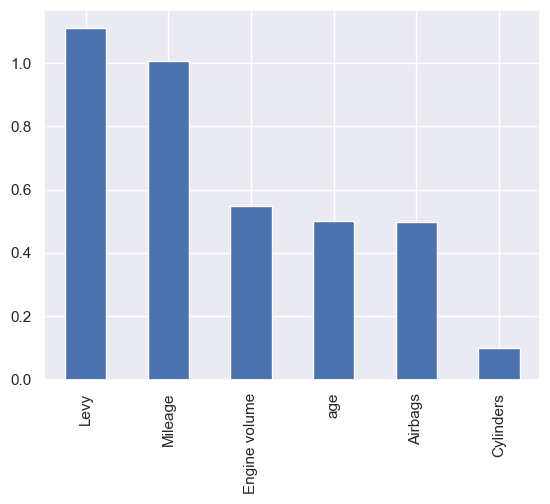

In [120]:
mutual_info.sort_values(ascending=False).plot(kind='bar')
plt.show()

In [121]:
X_train.drop('Cylinders', axis=1, inplace=True)
X_test.drop('Cylinders', axis=1, inplace=True)

In [122]:
x_numeric_train = X_train.select_dtypes('number')
x = sm.add_constant(x_numeric_train)
results = sm.OLS(y_train,x).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     457.7
Date:                Mon, 11 Dec 2023   Prob (F-statistic):               0.00
Time:                        11:16:24   Log-Likelihood:                -75543.
No. Observations:                6936   AIC:                         1.511e+05
Df Residuals:                    6930   BIC:                         1.511e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          3.834e+04    724.523     52.917      0.000    3.69e+04    3.98e+04
Levy             -2.7251      0.438     -6.224      0.000      -3.583      -1.867
Engine volume  3483.8761    295.463     11.791      0.000    2904.677    4063.075
Mileage          -0.0346      0.002    -22.209      0.000      -0.038      -0.032
Airbags        -918.3552     39.851    -23.045      0.000    -996.476    -840.234
age           -1532.3991     46.869    -32.695      0.000   -1624.277   -1440.521
==============================================================================
Omnibus:                      780.459   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1636.482
Skew:                           0.705   Prob(JB):                         0.00
Kurtosis:                       4.917   Cond. No.                     8.46e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.46e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

* <font color ='brown'>**All features are significance**</font>

## Data Preprossessing

In [123]:
categorical_preprocessor = Pipeline(
    steps = [('ohe', OneHotEncoder(drop='first'))]
)

In [124]:
numerical_preprocessor = Pipeline(
    steps = [('minmaxscaler' , MinMaxScaler())]
)

In [125]:
preprocessor = ColumnTransformer(
    [('categorical', categorical_preprocessor, list(X_train.select_dtypes('object').columns)),
    ('numerical', numerical_preprocessor, list(X_train.select_dtypes('number').columns))]   
)

In [126]:
preprocessor

ColumnTransformer(transformers=[('categorical',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(drop='first'))]),
                                 ['Manufacturer', 'Model', 'Category',
                                  'Leather interior', 'Fuel type',
                                  'Gear box type', 'Drive wheels', 'Doors',
                                  'Wheel', 'Color']),
                                ('numerical',
                                 Pipeline(steps=[('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['Levy', 'Engine volume', 'Mileage', 'Airbags',
                                  'age'])])

In [127]:
X_train_preproccessed = preprocessor.fit_transform(X_train)
X_test_preproccessed = preprocessor.transform(X_test)

In [128]:
X_train_preproccessed.shape

(6936, 63)

In [129]:
cval = KFold(n_splits=5, shuffle=True, random_state=99)

# Model Building

## Model Selection

### Linear Regression

In [130]:
models = []
avg_errors = []

In [131]:
lr = LinearRegression()

In [132]:
errors_lr = -cross_val_score(estimator=lr,                  
                X=X_train_preproccessed,
                y=y_train,
                cv=cval,
                scoring='neg_root_mean_squared_error')

print('Errors {}'.format(errors_lr))
print()
print('Avg_error {}'.format(np.mean(errors_lr)))

avg_errors.append(np.mean(errors_lr))
models.append('Linear Regression')

Errors [10259.80730526 10064.23750621  9887.84642482 10566.00340805
 11037.87395305]

Avg_error 10363.153719480364


### KNeighbours

#### find best number of neighbours

In [133]:
neighbors = []
errors = []

for i in range(1, 20):
    knn = KNeighborsRegressor(n_neighbors=i)
    model = knn.fit(X_train_preproccessed, y_train)
    error = np.mean(-cross_val_score(estimator=model,                  
                        X=X_train_preproccessed,
                        y=y_train,
                        cv=cval,
                        scoring='neg_root_mean_squared_error'))
    neighbors.append(i)
    errors.append(error)


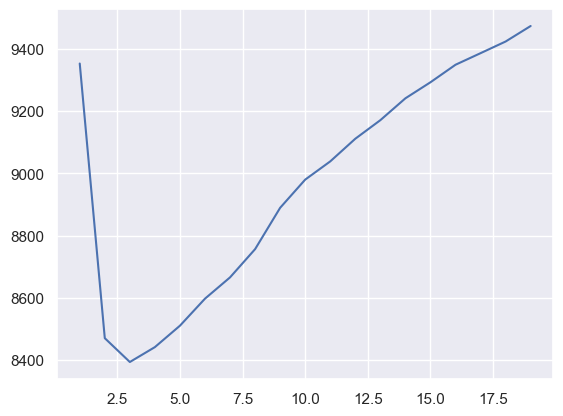

In [134]:
plt.plot(neighbors, errors)
plt.show()

In [135]:
np.argmin(errors)+1

3

In [136]:
knn = KNeighborsRegressor(n_neighbors=3)

In [137]:
errors_knn = -cross_val_score(estimator=knn,                  
                 X=X_train_preproccessed,
                 y=y_train,
                 cv=5,
                 scoring='neg_root_mean_squared_error')

print('Errors {}'.format(errors_knn))
print()
print('Avg_error {}'.format(np.mean(errors_knn)))

avg_errors.append(np.mean(errors_knn))
models.append('KNeighbors')  


Errors [8826.29103775 7759.73690584 7868.07473653 9574.76122789 8060.07331923]

Avg_error 8417.787445448


### Decision Tree

In [138]:
dt = DecisionTreeRegressor(random_state=99)

In [139]:
errors_dt = -cross_val_score(estimator=dt,                  
                 X=X_train_preproccessed,
                 y=y_train,
                 cv=cval,
                 scoring='neg_root_mean_squared_error')

print('Errors {}'.format(errors_dt))
print()
print('Avg_error {}'.format(np.mean(errors_dt)))

avg_errors.append(np.mean(errors_dt))
models.append('Decision Tree')  


Errors [7902.05806417 7597.53044631 7561.48324784 7380.62832251 7187.88784251]

Avg_error 7525.917584668755


### Random Forest

In [140]:
rf = RandomForestRegressor(random_state=99)

In [141]:
errors_rf = -cross_val_score(estimator=rf,                  
                 X=X_train_preproccessed,
                 y=y_train,
                 cv=cval,
                 scoring='neg_root_mean_squared_error')

print('Errors {}'.format(errors_rf))
print()
print('Avg_error {}'.format(np.mean(errors_rf)))

avg_errors.append(np.mean(errors_rf))
models.append('Random Forest')  

Errors [5939.54306646 5693.09383872 5786.19025069 5747.74470155 6406.14182017]

Avg_error 5914.542735518831


In [142]:
svr = SVR()

In [143]:
errors_svr = -cross_val_score(estimator=svr,                  
                 X=X_train_preproccessed,
                 y=y_train,
                 cv=cval,
                 scoring='neg_root_mean_squared_error')

print('Errors {}'.format(errors_svr))
print()
print('Avg_error {}'.format(np.mean(errors_svr)))

avg_errors.append(np.mean(errors_svr))
models.append('SVR')  

Errors [14993.9372215  14713.52623234 14675.87256678 15373.81407605
 15875.89183278]

Avg_error 15126.608385889098


In [144]:
compare_models = pd.DataFrame({'Model':models, 'MSE':avg_errors}).sort_values(by='MSE', ascending=True)
compare_models

,Model,MSE
3,Random Forest,5914.542736
2,Decision Tree,7525.917585
1,KNeighbors,8417.787445
0,Linear Regression,10363.153719
4,SVR,15126.608386


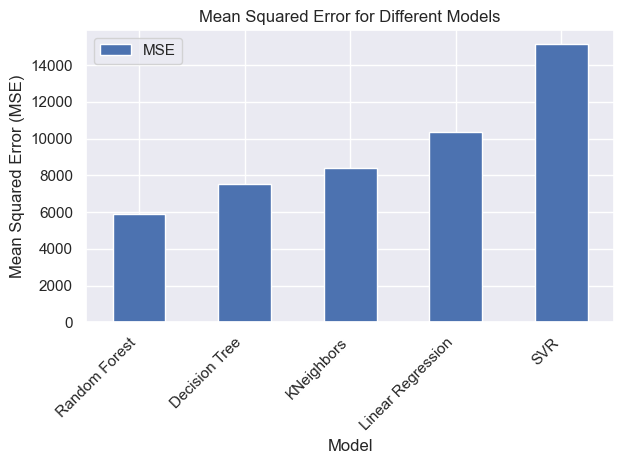

In [145]:
compare_models.plot(kind = 'bar')
plt.xlabel('Model')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Mean Squared Error for Different Models')
plt.xticks(range(len(compare_models)) ,compare_models['Model'] ,rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()

<font color = 'brown'>**Random forest is the best performing Model**</font>

# Hyper parameter Tuning

In [191]:
rf = RandomForestRegressor(random_state=99)

In [192]:
parameters = {
    'n_estimators': range(50,501),
    'max_features':['sqrt', 'log2', None],
    'bootstrap':[True, False],
    'min_samples_split':range(2,101) 
}

In [193]:
randomsearch = RandomizedSearchCV(
                estimator= rf,
                param_distributions= parameters,
                n_iter= 100,
                cv= cval,
                scoring='neg_root_mean_squared_error',
                verbose=2
                )

In [194]:
randomsearch.fit(X_train_preproccessed,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=False, max_features=None, min_samples_split=63, n_estimators=484; total time=  41.6s
[CV] END bootstrap=False, max_features=None, min_samples_split=63, n_estimators=484; total time=  41.7s
[CV] END bootstrap=False, max_features=None, min_samples_split=63, n_estimators=484; total time=  42.0s
[CV] END bootstrap=False, max_features=None, min_samples_split=63, n_estimators=484; total time=  44.2s
[CV] END bootstrap=False, max_features=None, min_samples_split=63, n_estimators=484; total time=  41.8s
[CV] END bootstrap=False, max_features=None, min_samples_split=74, n_estimators=483; total time=  37.6s
[CV] END bootstrap=False, max_features=None, min_samples_split=74, n_estimators=483; total time=  39.2s
[CV] END bootstrap=False, max_features=None, min_samples_split=74, n_estimators=483; total time=  35.6s
[CV] END bootstrap=False, max_features=None, min_samples_split=74, n_estimators=483; total time=  37.8s
[

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=99, shuffle=True),
                   estimator=RandomForestRegressor(random_state=99), n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_split': range(2, 101),
                                        'n_estimators': range(50, 501)},
                   scoring='neg_root_mean_squared_error', verbose=2)

In [195]:
randomsearch.best_params_

{'n_estimators': 374,
 'min_samples_split': 5,
 'max_features': None,
 'bootstrap': True}

In [196]:
randomsearch.best_score_

-5893.188032473122

In [197]:
model = randomsearch.best_estimator_
model

RandomForestRegressor(max_features=None, min_samples_split=5, n_estimators=374,
                      random_state=99)

In [199]:
model.fit(X_train_preproccessed, y_train)

RandomForestRegressor(max_features=None, min_samples_split=5, n_estimators=374,
                      random_state=99)

In [200]:
model.score(X_train_preproccessed, y_train)

0.964919785201775

In [201]:
model.score(X_test_preproccessed, y_test)

0.8654006481476677

In [202]:
predicted = model.predict(X_test_preproccessed)

In [203]:
np.sqrt(mean_squared_error(y_test, predicted))

5627.184506129518

In [204]:
errors = y_test - predicted

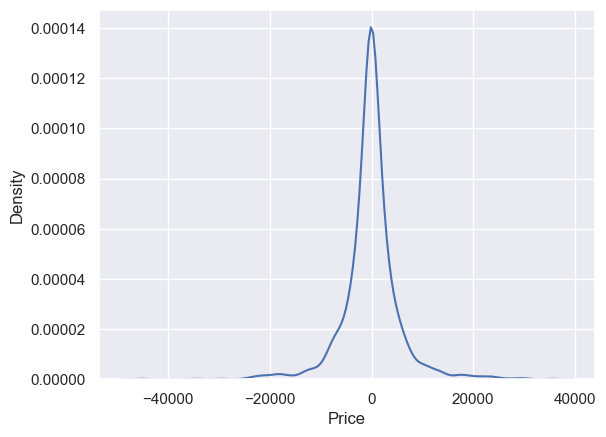

In [205]:
sns.kdeplot(errors)
plt.show()

* <font color = 'brown'>**Errors are normally ditributed around mean zero**</font>

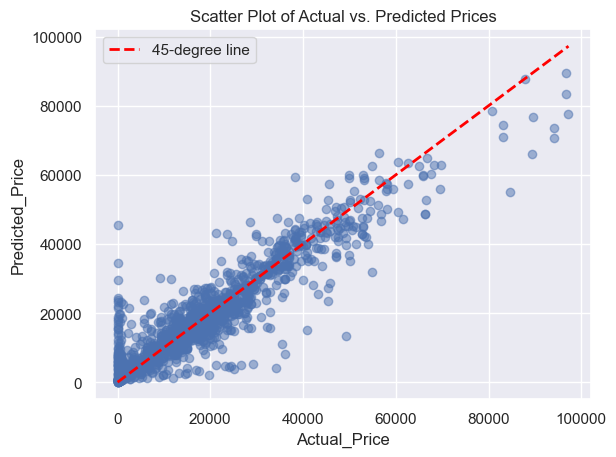

In [206]:
plt.scatter(y_test, predicted, alpha=0.5) 
plt.xlabel('Actual_Price')
plt.ylabel('Predicted_Price')
plt.title('Scatter Plot of Actual vs. Predicted Prices')

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', lw=2, label='45-degree line')

plt.xlabel('Actual_Price')
plt.ylabel('Predicted_Price')
plt.legend()

plt.show()

* <font color = 'brown'>**Most data points are around 45 degree line**</font>

## Try without Color feature

In [146]:
X_train_new = X_train.drop('Color', axis=1)
X_test_new = X_test.drop('Color', axis=1)

In [147]:
X_test_new

,Levy,Engine volume,Mileage,Airbags,age,Manufacturer,Model,Category,Leather interior,Fuel type,Gear box type,Drive wheels,Doors,Wheel
94,639,2.0,120000.0,4,9,HYUNDAI,Tucson,Jeep,Yes,Diesel,Automatic,Front,4,Left wheel
1078,400,1.5,70720.0,12,5,CHEVROLET,Volt,Sedan,Yes,Hybrid,Automatic,Front,4,Left wheel
579,1053,3.5,146395.0,12,9,MERCEDES-BENZ,E 350,Sedan,Yes,Diesel,Automatic,Rear,4,Left wheel
4019,645,1.8,172502.0,12,12,HYUNDAI,Elantra,Jeep,Yes,Petrol,Automatic,Front,4,Left wheel
2046,1399,3.5,205968.0,12,13,MERCEDES-BENZ,E 350,Sedan,Yes,Petrol,Automatic,4x4,4,Left wheel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3362,1091,2.5,48800.0,4,7,HYUNDAI,H1,Minivan,Yes,Diesel,Automatic,Front,4,Left wheel
1310,915,3.0,110715.0,0,9,BMW,X5,Jeep,Yes,Diesel,Automatic,4x4,4,Left wheel
3040,0,1.5,150000.0,0,17,TOYOTA,Prius,Sedan,No,Hybrid,Automatic,Front,4,Left wheel
0,0,1.3,200000.0,2,17,HONDA,FIT,Hatchback,No,Petrol,Variator,Front,4,Right-hand drive


In [148]:
preprocessor_new = ColumnTransformer(
    [('categorical', categorical_preprocessor, list(X_train_new.select_dtypes('object').columns)),
    ('numerical', numerical_preprocessor, list(X_train_new.select_dtypes('number').columns))]   
)

In [149]:
X_train_preproccessed_new = preprocessor_new.fit_transform(X_train_new)
X_test_preproccessed_new = preprocessor_new.transform(X_test_new)

In [150]:
model_new = RandomForestRegressor(n_estimators=374,
                                 min_samples_split=5,
                                 max_features=None,
                                 bootstrap=True,
                                 random_state=99)

In [151]:
model_new.fit(X_train_preproccessed_new, y_train)

RandomForestRegressor(max_features=None, min_samples_split=5, n_estimators=374,
                      random_state=99)

In [152]:
model_new.score(X_train_preproccessed_new, y_train)

0.961954754713227

In [153]:
model_new.score(X_test_preproccessed_new, y_test)

0.8636966036767835

In [154]:
predicted_new = model_new.predict(X_test_preproccessed_new)

In [155]:
np.sqrt(mean_squared_error(y_test, predicted_new))

5662.692900947631

* <font color = 'brown'>**does not have any significance influence in color feature**</font>
* <font color = 'brown'>**remove it from model**</font>

In [229]:
model_new_2 = RandomForestRegressor(max_features=None, bootstrap=True, random_state=99)

In [236]:
parameters = {
    'n_estimators': [370, 374, 380, 390, 400],
    'min_samples_split':[3 ,5, 7, 9]
}

In [242]:
gridsearch = GridSearchCV(
    estimator= model_new_2,
    param_grid=parameters,
    cv = cval,
    scoring='neg_root_mean_squared_error',
    verbose=2
)

In [244]:
gridsearch.fit(X_train_preproccessed_new, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ..............min_samples_split=3, n_estimators=370; total time= 1.0min
[CV] END ..............min_samples_split=3, n_estimators=370; total time= 1.1min
[CV] END ..............min_samples_split=3, n_estimators=370; total time= 1.0min
[CV] END ..............min_samples_split=3, n_estimators=370; total time= 1.1min
[CV] END ..............min_samples_split=3, n_estimators=370; total time= 1.1min
[CV] END ..............min_samples_split=3, n_estimators=374; total time= 1.1min
[CV] END ..............min_samples_split=3, n_estimators=374; total time= 1.0min
[CV] END ..............min_samples_split=3, n_estimators=374; total time= 1.0min
[CV] END ..............min_samples_split=3, n_estimators=374; total time= 1.0min
[CV] END ..............min_samples_split=3, n_estimators=374; total time= 1.0min
[CV] END ..............min_samples_split=3, n_estimators=380; total time= 1.1min
[CV] END ..............min_samples_split=3, n_e

GridSearchCV(cv=KFold(n_splits=5, random_state=99, shuffle=True),
             estimator=RandomForestRegressor(max_features=None,
                                             random_state=99),
             param_grid={'min_samples_split': [3, 5, 7, 9],
                         'n_estimators': [370, 374, 380, 390, 400]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [245]:
gridsearch.best_params_

{'min_samples_split': 3, 'n_estimators': 400}

In [246]:
gridsearch.best_score_

-5931.407562332542

In [247]:
model = gridsearch.best_estimator_

In [248]:
model.fit(X_train_preproccessed_new, y_train)

RandomForestRegressor(max_features=None, min_samples_split=3, n_estimators=400,
                      random_state=99)

In [250]:
model.score(X_train_preproccessed_new, y_train)

0.973163018748307

In [251]:
model.score(X_test_preproccessed_new, y_test)

0.8619313655193832

In [187]:
import pickle
with open('car_price_prediction_model.pickle','wb') as f:
    pickle.dump(model_new,f)

In [192]:
import pickle
with open('preprocessor_new.pickle','wb') as f:
    pickle.dump(preprocessor_new,f)

In [161]:
for col in X_train_new.select_dtypes('object').columns:
    print('{} : {}'.format(col ,X_train[col].unique()))
    print()

Manufacturer : ['MERCEDES-BENZ' 'HYUNDAI' 'TOYOTA' 'HONDA' 'FORD' 'CHEVROLET' 'BMW']

Model : ['E 350' 'Sonata' 'Camry' 'Santa FE' 'FIT' 'Highlander' 'Prius' 'Tucson'
 'Transit' 'Elantra' 'H1' 'Fusion' 'Aqua' 'Volt' 'Escape' 'Cruze' 'X5'
 'RAV 4' 'ML 350' 'Civic' 'Captiva']

Category : ['Sedan' 'Jeep' 'Hatchback' 'Microbus' 'Universal' 'Minivan']

Leather interior : ['Yes' 'No']

Fuel type : ['Diesel' 'Hybrid' 'Petrol' 'LPG' 'CNG']

Gear box type : ['Automatic' 'Tiptronic' 'Manual' 'Variator']

Drive wheels : ['Rear' 'Front' '4x4']

Doors : ['4' '2']

Wheel : ['Left wheel' 'Right-hand drive']



In [164]:
import json

categorical_columns = {
    'Manufacturer' : ['MERCEDES-BENZ','HYUNDAI','TOYOTA','HONDA','FORD','CHEVROLET','BMW'],
    'Model' : ['E 350','Sonata','Camry','Santa FE','FIT','Highlander','Prius','Tucson','Transit','Elantra','H1','Fusion','Aqua',
             'Volt','Escape','Cruze','X5','RAV 4','ML 350','Civic','Captiva'],
    'Category' : ['Sedan','Jeep','Hatchback','Microbus','Universal','Minivan'],
    'Leather interior' : ['Yes','No'],
    'Fuel type' : ['Diesel','Hybrid','Petrol','LPG','CNG'],
    'Gear box type' : ['Automatic','Tiptronic','Manual','Variator'],
    'Drive wheels' : ['Rear','Front','4x4'],
    'Doors' : ['4','2'],
    'Wheel' : ['Left wheel','Right-hand drive']  
}

with open('categorical_columns.json', 'w') as f:
    json.dump(categorical_columns, f)

In [165]:
X_train_new.columns

Index(['Levy', 'Engine volume', 'Mileage', 'Airbags', 'age', 'Manufacturer',
       'Model', 'Category', 'Leather interior', 'Fuel type', 'Gear box type',
       'Drive wheels', 'Doors', 'Wheel'],
      dtype='object')

In [183]:
def predict_price(Levy, Engine_volume, Mileage, Airbags, age, Manufacturer,Model, Category, Leather_interior, 
                  Fuel_type, Gear_box_type,Drive_wheels, Doors, Wheel):
    input = {'Levy':[Levy], 
             'Engine volume':[Engine_volume], 
             'Mileage':[Mileage], 
             'Airbags':[Airbags], 
             'age':[age], 
             'Manufacturer':[Manufacturer],
             'Model':[Model], 
             'Category':[Category], 
             'Leather interior':[Leather_interior], 
             'Fuel type':[Fuel_type], 
             'Gear box type':[Gear_box_type],
             'Drive wheels':[Drive_wheels], 
             'Doors':[Doors], 
             'Wheel':[Wheel]}

    input_df = pd.DataFrame(input)
    preprocessed_data = preprocessor_new.transform(input_df)
    prediction = model_new.predict(preprocessed_data)
    return prediction
    

In [193]:
predict_price(1055, 3.5, 107800.0, 12, 10, 'MERCEDES-BENZ', 'E 350', 'Sedan',
       'Yes', 'Diesel', 'Automatic', 'Rear', '4', 'Left wheel')

array([5479.0188749])